
# FODA del Equipo de Liderazgo Informático — Cuadernillo de Análisis

**Coordinación:** Lizzy Pamela Mejía — `lpmejiam@unah.hn`  
**Objetivo:** Analizar resultados del formulario Microsoft Forms para:  
1) calcular fortalezas y brechas por persona y por equipo,  
2) estimar *role-fit* por perfiles (PM/Líder, Backend/API, Frontend/UX, Data/ML, QA, DevOps),  
3) **recomendar áreas de capacitación** a cada miembro basadas en Debilidades y Amenazas.

> **Entrada esperada:** un Excel exportado desde Microsoft Forms
> **Formulario Base:** https://forms.office.com/r/RzCD2wiugF


In [90]:
# ===== Celda 1: CARGA + VERIFICACIÓN =====
!pip -q install openpyxl > /dev/null

import os, re
import pandas as pd
from io import BytesIO

OUTPUT_DIR = "/content/foda_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========= OPCIÓN A) SUBIR DESDE TU PC =========
USE_OPTION = "A"  # <-- Cambia a "B" o "C" si usarás otra opción

if USE_OPTION == "A":
    from google.colab import files
    print(">> Opción A: Sube tu archivo .xlsx exportado de Microsoft Forms")
    up = files.upload()  # Selecciona el .xlsx
    if not up:
        raise SystemExit("No se subió ningún archivo. Vuelve a ejecutar y elige el .xlsx.")
    INPUT_XLSX = list(up.keys())[0]
    df_raw = pd.read_excel(INPUT_XLSX)


# ====== Verificación básica ======
print("Cargado correctamente.")
print("Columnas detectadas:\n", list(df_raw.columns))

# Guardar pkl para consumir en la celda 2 (evita repetir carga)
pkl_path = "/content/_foda_respuestas.pkl"
df_raw.to_pickle(pkl_path)
print(f"↳ DataFrame guardado en: {pkl_path}")


>> Opción A: Sube tu archivo .xlsx exportado de Microsoft Forms


Saving FODA del Equipo de Liderazgo Informático – Mapeo de Capacidades y Roles(1-7).xlsx to FODA del Equipo de Liderazgo Informático – Mapeo de Capacidades y Roles(1-7) (1).xlsx
Cargado correctamente.
Columnas detectadas:
 ['ID', 'Start time', 'Completion time', 'Email', 'Name', 'Last modified time', 'Nombre completo:\n', 'URL de LinkedIn:', 'Semestre actual:', 'Áreas de interés principal:', 'Programación: Python', 'Programación: JavaScript/TypeScript', 'Frameworks web (React/Angular/Vue)', 'Backend (Node/Express, APIs REST, Auth/JWT', 'Bases de datos SQL (modelado, consultas, normalización)', 'Bases de datos NoSQL (Mongo/Redis/Firebase)', 'Datos/ML (Pandas, scikit-learn, EDA, métricas)', 'DevOps/Cloud (Docker, CI/CD, AWS/Azure/GCP)', 'Ciberseguridad (hardening, buenas prácticas)', 'Redes (routing/switching, VLAN, protocolos)', 'QA/Testing (unit/integration, coverage, TDD)', 'UX/UI (wireframes, heurísticas, handoff)', 'Certificaciones o cursos relevantes (lista corta):\xa0', 'Años/mese

## Cargar datos y mapear columnas

In [91]:
# Cargar Excel
try:
    df_raw = pd.read_excel(INPUT_XLSX)
except Exception as e:
    raise SystemExit(f'No se pudo abrir {INPUT_XLSX}. Sube primero el Excel exportado de Microsoft Forms. Error: {e}')

print('Columnas detectadas:')
print(list(df_raw.columns))

# Normalmente Microsoft Forms incluye columnas de tiempo/ID; intentamos limpiar
df = df_raw.copy()

# --- Config de mapeo por palabras clave (ajústalas si tu encabezado es distinto) ---
# Usa cualquier fragmento contenido en las preguntas reales del formulario.
MAP = {
    'nombre':            [r'nombre', r'Nombre completo'],
    'linkedin':          [r'linkedin', r'URL de LinkedIn'],
    'debilidades_text':  [r'Debilidades', r'¿Qué te limita'],
    'amenazas_text':     [r'Amenazas', r'¿Qué factores externos'],
}

# Competencias Likert 1–5 (agrega/ajusta patrones para que coincidan con tus preguntas)
LIKERT_GROUPS = {
    'programacion_python':      [r'Programación.*Python'],
    'js_ts':                    [r'JavaScript', r'TypeScript'],
    'frameworks_web':           [r'Frameworks web', r'React|Angular|Vue'],
    'backend_api':              [r'Backend', r'APIs REST', r'Auth|JWT'],
    'sql':                      [r'Bases de datos SQL'],
    'nosql':                    [r'NoSQL|Mongo|Redis|Firebase'],
    'datos_ml':                 [r'Datos/ML|Pandas|scikit|EDA'],
    'devops_cloud':             [r'DevOps|Cloud|Docker|CI/CD|AWS|Azure|GCP'],
    'ciberseguridad':           [r'Ciberseguridad|OWASP|hardening'],
    'redes':                    [r'Redes|routing|switching|VLAN|protocolos'],
    'qa_testing':               [r'QA|Testing|TDD|coverage'],
    'ux_ui':                    [r'UX/UI|wireframes|heurísticas|heuristicas|handoff'],
    'scrum_kanban':             [r'metodolog', r'Scrum|Kanban'],
    'proactividad':             [r'Proactividad'],
    'comunicacion':             [r'Comunicación'],
    'colaboracion':             [r'Colaboración'],
    'aprendizaje_rapido':       [r'Aprendizaje rápido|Aprendizaje rapido'],
    'gestion_tiempo':           [r'Gestión del tiempo|Gestion del tiempo|prioriz'],
    'resiliencia':              [r'Resiliencia|presión|presion|deadlines'],
    'analitico':                [r'analític|analitic'],
    'creatividad':              [r'Creatividad'],
    'negocio':                  [r'negocio|KPI|costos|valor'],
    'descubrimiento_producto':  [r'Descubrimiento de producto|entrevistas|pruebas con usuarios'],
    'presentaciones':           [r'Presentaciones|storytelling'],
    'relacion_cliente':         [r'Relación con cliente|Relacion con cliente|usuarios|soporte|empatía|empatia'],
    'docencia':                 [r'docencia|tutor'],
    'investigacion':            [r'investigaci'],
    'ingles':                   [r'Inglés técnico|Ingles tecnico|English'],
}

def find_column(patterns):
    """Encuentra la primera columna cuyo nombre coincide con alguno de los patrones (regex, case-insensitive)."""
    for p in patterns:
        regex = re.compile(p, re.IGNORECASE)
        for c in df.columns:
            if regex.search(str(c)):
                return c
    return None

def find_columns(patterns):
    cols = []
    for p in patterns:
        regex = re.compile(p, re.IGNORECASE)
        for c in df.columns:
            if regex.search(str(c)):
                cols.append(c)
    # quitar duplicados preservando orden
    seen = set()
    return [x for x in cols if not (x in seen or seen.add(x))]

# Mapear columnas clave
col_nombre   = find_column(MAP['nombre']) or 'Nombre'
col_linkedin = find_column(MAP['linkedin']) or 'LinkedIn'
col_deb      = find_column(MAP['debilidades_text'])
col_ame      = find_column(MAP['amenazas_text'])

if col_nombre not in df.columns:
    raise SystemExit('No se encontró la columna de Nombre. Ajusta MAP[\"nombre\"] para que coincida con tu archivo.')

# Crear vista con columnas útiles
df['__Nombre'] = df[col_nombre]
if col_linkedin in df.columns:
    df['__LinkedIn'] = df[col_linkedin]
else:
    df['__LinkedIn'] = ''

if col_deb in df.columns:
    df['__Debilidades'] = df[col_deb].fillna('')
else:
    df['__Debilidades'] = ''

if col_ame in df.columns:
    df['__Amenazas'] = df[col_ame].fillna('')
else:
    df['__Amenazas'] = ''

# Detectar columnas Likert por grupo
likert_map = {}
for group, patterns in LIKERT_GROUPS.items():
    cols = find_columns(patterns)
    if cols:
        likert_map[group] = cols

print('\nGrupos Likert detectados (preguntas encontradas por grupo):')
for k, v in likert_map.items():
    print(f'- {k}: {v if v else "N/A"}')

Columnas detectadas:
['ID', 'Start time', 'Completion time', 'Email', 'Name', 'Last modified time', 'Nombre completo:\n', 'URL de LinkedIn:', 'Semestre actual:', 'Áreas de interés principal:', 'Programación: Python', 'Programación: JavaScript/TypeScript', 'Frameworks web (React/Angular/Vue)', 'Backend (Node/Express, APIs REST, Auth/JWT', 'Bases de datos SQL (modelado, consultas, normalización)', 'Bases de datos NoSQL (Mongo/Redis/Firebase)', 'Datos/ML (Pandas, scikit-learn, EDA, métricas)', 'DevOps/Cloud (Docker, CI/CD, AWS/Azure/GCP)', 'Ciberseguridad (hardening, buenas prácticas)', 'Redes (routing/switching, VLAN, protocolos)', 'QA/Testing (unit/integration, coverage, TDD)', 'UX/UI (wireframes, heurísticas, handoff)', 'Certificaciones o cursos relevantes (lista corta):\xa0', 'Años/meses de experiencia previa (académica/proyectos/empleo)', 'Roles que sueles desempeñar \n', 'Preferencia de rol para este grupo', 'Comodidad trabajando con metodologías (Scrum/Kanban)\xa0', 'Proactividad p

In [92]:
display(df_raw)

ID          Start time     Completion time                    Email  \
0   1 2025-10-03 21:05:35 2025-10-03 21:17:57       katie.chiu@unah.hn   
1   2 2025-10-03 21:35:47 2025-10-03 21:54:37      erchavarria@unah.hn   
2   3 2025-10-04 20:29:40 2025-10-04 20:42:34    jackyr.discua@unah.hn   
3   4 2025-10-04 22:20:43 2025-10-04 22:46:38  heysser.machado@unah.hn   
4   5 2025-10-04 23:08:55 2025-10-04 23:28:54  lester.bustillo@unah.hn   
5   6 2025-10-04 23:20:25 2025-10-04 23:29:08     erick.blanco@unah.hn   
6   7 2025-10-07 04:15:21 2025-10-07 04:25:59         lpmejiam@unah.hn   

                            Name  Last modified time  \
0     KATIE LAI YIN CHIU VASQUEZ                 NaN   
1  EDUIN RAMON CHAVARRIA MACHADO                 NaN   
2    JACKYR ANTONIO DISCUA CALIX                 NaN   
3   HEYSSER JAVIER MACHADO MEJIA                 NaN   
4  LESTER ARIEL BUSTILLO BONILLA                 NaN   
5      ERICK DAVID BLANCO SANTOS                 NaN   
6       LIZZY PAMELA MEJIA MEJIA                 NaN   

               Nombre completo:\n  \
0     Katie Lai Yin Chiu Vásquez    
1  Eduin Ramón Chavarría Machado    
2     Jackyr Antonio Discua Calix   
3   Heysser Javier Machado Mejía    
4                 Lester Bustillo   
5       Erick David Blanco Santos   
6        Lizzy Pamela Mejia Mejia   

                                    URL de LinkedIn:        Semestre actual:  \
0          https://www.linkedin.com/in/katielai-chiu          Decimo Tercero   
1  https://www.linkedin.com/in/eduin-ramon-chavar...          Decimo Tercero   
2              https://www.linkedin.com/in/jackyr-dc  Menor a Decimo Tercero   
3  https://www.linkedin.com/in/heysser-javier-mac...  Menor a Decimo Tercero   
4  https://www.linkedin.com/in/lester-bustillo-b8...  Menor a Decimo Tercero   
5  https://www.linkedin.com/in/erick-david-blanco...          Decimo Tercero   
6  https://www.linkedin.com/in/lizzy-pamela-mejia...          Decimo Tercero   

                         Áreas de interés principal:  ...  \
0      Desarrollo backend ;Ciberseguridad;Docencia ;  ...   
1                    Redes;Docencia ;Emprendimiento;  ...   
2           DevOps/Cloud;Datos/ML/IA;Investigación ;  ...   
3  Docencia ;Gestión de Proyectos;Desarrollo back...  ...   
4  Gestión de Proyectos;Analítica de negocios ;Em...  ...   
5  Desarrollo backend ;Desarrollo frontend;Cibers...  ...   
6   Datos/ML/IA;Investigación ;Gestión de Proyectos;  ...   

   Disponibilidad semanal (horas reales dedicables)  \
0                                             3-5 h   
1                                             3-5 h   
2                                            9-12 h   
3                                            9-12 h   
4                                             6-8 h   
5                                             6-8 h   
6                                             17+ h   

   Franja horaria preferente   \
0                       Noche   
1                       Noche   
2                       Tarde   
3                       Tarde   
4                       Tarde   
5                       Noche   
6                    Flexible   

   Restricciones importantes (clases, trabajo, hijos, enfermedades mentales, etc.)  \
0                                    Clases, trabajo                                 
1                                  No detectadas aun                                 
2                                            Clases                                  
3                                            Clases                                  
4                                   Clases, trabajo                                  
5                                                 No                                 
6                              Enfermedades mentales                                 

   Motivación principal en el grupo  Estilo de aprendizaje preferido  \
0               Aprender tecnología                            Mixt

## Normalización y puntajes compuestos

In [93]:
# Convertir respuestas Likert a numérico y normalizar a 0–1 (1->0, 5->1)
def to_numeric_series(s):
    return pd.to_numeric(s, errors='coerce')

def normalize_series(s):
    return (s - 1.0) / 4.0

# Promedio por grupo
group_scores = {}
for group, cols in likert_map.items():
    vals = []
    for c in cols:
        vals.append(normalize_series(to_numeric_series(df[c])))
    if vals:
        group_scores[group] = pd.concat(vals, axis=1).mean(axis=1)

scores_df = pd.DataFrame(group_scores)
scores_df.index = df['__Nombre']
scores_df.to_csv(os.path.join(OUTPUT_DIR, 'scores_normalizados_por_grupo.csv'), encoding='utf-8', index=True)
print('Guardado: scores_normalizados_por_grupo.csv')
display(scores_df)

Guardado: scores_normalizados_por_grupo.csv


programacion_python  js_ts  frameworks_web  \
__Nombre                                                                     
Katie Lai Yin Chiu Vásquez                     0.75   0.75            0.75   
Eduin Ramón Chavarría Machado                  0.25   0.50            0.50   
Jackyr Antonio Discua Calix                    0.50   1.00            0.75   
Heysser Javier Machado Mejía                   0.50   0.25            0.25   
Lester Bustillo                                0.50   0.50            0.50   
Erick David Blanco Santos                      1.00   0.75            0.75   
Lizzy Pamela Mejia Mejia                       0.75   0.75            0.25   

                                backend_api   sql  nosql  datos_ml  \
__Nombre                                                             
Katie Lai Yin Chiu Vásquez             1.00  0.75   0.50      0.25   
Eduin Ramón Chavarría Machado          0.25  0.50   0.25      0.25   
Jackyr Antonio Discua Calix            0.75  1.00   0.75      0.75   
Heysser Javier Machado Mejía           0.50  0.50   0.50      0.50   
Lester Bustillo                        0.50  0.50   0.75      0.25   
Erick David Blanco Santos              0.75  0.50   0.50      0.50   
Lizzy Pamela Mejia Mejia               0.75  0.75   0.75      0.75   

                                devops_cloud  ciberseguridad  redes  ...  \
__Nombre                                                             ...   
Katie Lai Yin Chiu Vásquez              0.00            0.75   0.75  ...   
Eduin Ramón Chavarría Machado           0.50            0.75   1.00  ...   
Jackyr Antonio Discua Calix             0.50            0.25   1.00  ...   
Heysser Javier Machado Mejía            0.50            0.50   0.50  ...   
Lester Bustillo                         0.25            0.25   0.50  ...   
Erick David Blanco Santos               0.00            0.50   0.75  ...   
Lizzy Pamela Mejia Mejia                0.00            0.25   0.75  ...   

                                gestion_tiempo  resiliencia  analitico  \
__Nombre                                                                 
Katie Lai Yin Chiu Vásquez                1.00         0.75       1.00   
Eduin Ramón Chavarría Machado             0.50         0.75       1.00   
Jackyr Antonio Discua Calix               0.75         1.00       1.00   
Heysser Javier Machado Mejía              0.75         0.75       0.75   
Lester Bustillo                           0.75         0.75       1.00   
Erick David Blanco Santos                 0.75         0.50       1.00   
Lizzy Pamela Mejia Mejia                  0.75         1.00       0.75   

                                creatividad  negocio  descubrimiento_producto  \
__Nombre                                                                        
Katie Lai Yin Chiu Vásquez             1.00     0.50                     0.25   
Eduin Ramón Chavarría Machado          1.00     0.50                     1.00   
Jackyr Antonio Discua Calix            1.00     0.75                     0.75   
Heysser Javier Machado Mejía           0.75     0.75                     0.75   
Lester Bustillo                        1.00     1.00                     1.00   
Erick David Blanco Santos              1.00     0.25                     0.25   
Lizzy Pamela Mejia Mejia               1.00     0.75                     0.75   

                                presentaciones  relacion_cliente  docencia  \
__Nombre                                                                     
Katie Lai Yin Chiu Vásquez                0.25             0.250      1.00   
Eduin Ramón Chavarría Machado             1.00             1.000      0.75   
Jackyr Antonio Discua Calix               0.75             0.625      1.00   
Heysser Javier Machado Mejía              0.75             0.750      0.75   
Lester Bustillo                           0.75             1.000      0.75   
Erick David Blanco Santos                 0.25             0.125      

## Puntaje de encaje por rol (*role-fit*)

In [94]:
import numpy as np # Import numpy

# Definición de vectores de rol (pesos por grupo). Ajusta según necesidades.
ROLE_WEIGHTS = {
    'PM_Lider': {
        'comunicacion': 1.0, 'colaboracion': 0.8, 'gestion_tiempo': 0.8,
        'negocio': 0.8, 'presentaciones': 0.7, 'scrum_kanban': 0.9, 'proactividad': 0.6
    },
    'Backend_API': {
        'backend_api': 1.0, 'sql': 0.9, 'nosql': 0.7, 'devops_cloud': 0.6, 'qa_testing': 0.6, 'ciberseguridad': 0.4
    },
    'Frontend_UX': {
        'js_ts': 1.0, 'frameworks_web': 0.9, 'ux_ui': 0.9, 'comunicacion': 0.5, 'presentaciones': 0.4
    },
    'Data_ML': {
        'programacion_python': 0.9, 'datos_ml': 1.0, 'sql': 0.8, 'analitico': 0.8, 'gestion_tiempo': 0.4
    },
    'QA': {
        'qa_testing': 1.0, 'gestion_tiempo': 0.7, 'resiliencia': 0.6, 'analitico': 0.6, 'comunicacion': 0.4
    },
    'DevOps': {
        'devops_cloud': 1.0, 'backend_api': 0.6, 'ciberseguridad': 0.5, 'redes': 0.5, 'qa_testing': 0.4
    }
}

def compute_role_fit(scores_row, weights):
    # suma ponderada / suma de pesos, usando 0 si falta algún grupo
    num = 0.0
    den = 0.0
    for g, w in weights.items():
        val = float(scores_row.get(g, np.nan))
        if not pd.isna(val):
            num += val * w
            den += w
    return num / den if den > 0 else np.nan

role_fit = {}
for role, w in ROLE_WEIGHTS.items():
    role_fit[role] = scores_df.apply(lambda row: compute_role_fit(row, w), axis=1)

role_fit_df = pd.DataFrame(role_fit)
role_fit_df.index = scores_df.index
role_fit_df.to_csv(os.path.join(OUTPUT_DIR, 'role_fit_scores.csv'), encoding='utf-8', index=True)
print('Guardado: role_fit_scores.csv')
display(role_fit_df)

Guardado: role_fit_scores.csv


PM_Lider  Backend_API  Frontend_UX   Data_ML  \
__Nombre                                                                       
Katie Lai Yin Chiu Vásquez      0.727679     0.553571     0.547297  0.698718   
Eduin Ramón Chavarría Machado   0.665179     0.422619     0.493243  0.480769   
Jackyr Antonio Discua Calix     0.816964     0.684524     0.635135  0.794872   
Heysser Javier Machado Mejía    0.683036     0.500000     0.432432  0.576923   
Lester Bustillo                 0.638393     0.482143     0.527027  0.564103   
Erick David Blanco Santos       0.656250     0.416667     0.547297  0.743590   
Lizzy Pamela Mejia Mejia        0.767857     0.488095     0.439189  0.750000   

                                      QA    DevOps  
__Nombre                                            
Katie Lai Yin Chiu Vásquez      0.651515  0.450000  
Eduin Ramón Chavarría Machado   0.636364  0.575000  
Jackyr Antonio Discua Calix     0.765152  0.591667  
Heysser Javier Machado Mejía    0.674242  0.500000  
Lester Bustillo                 0.689394  0.375000  
Erick David Blanco Santos       0.553030  0.358333  
Lizzy Pamela Mejia Mejia        0.537879  0.316667

## Recomendaciones de capacitación (basadas en Debilidades/Amenazas + brechas numéricas)

In [95]:

# Diccionario de palabras clave -> áreas de capacitación sugeridas
KEYWORD_TRAINING = {
    'tiempo|prioriz': 'Gestión del tiempo y priorización (técnicas Pomodoro/OKR/kanban personal)',
    'comunica|presenta|story': 'Comunicación y presentaciones técnicas (storytelling, pitch, visualización)',
    'lider|scrum|kanban|pm': 'Gestión ágil (Scrum/Kanban), liderazgo de equipos',
    'python|pandas|ml|data|scikit': 'Ciencia de datos con Python (Pandas, scikit-learn, EDA)',
    'sql|relacion': 'Modelado y consultas SQL (JOINs, índices, normalización)',
    'nosql|mongo|redis|firebase': 'Diseño y operación de bases NoSQL',
    'backend|api|node|express|jwt|rest': 'Diseño de APIs REST con Node/Express y autenticación JWT',
    'frontend|react|angular|vue|ui|ux': 'Frontend moderno y UX (React/Angular/Vue, heurísticas de UX)',
    'devops|docker|ci|cd|aws|azure|gcp|kubernetes': 'DevOps/Cloud (Docker, CI/CD, despliegue en nube)',
    'seguridad|owasp|harden|vulnerab': 'Ciberseguridad aplicada (OWASP Top 10, hardening)',
    'redes|vlan|routing|switching': 'Redes (VLAN, routing/switching, troubleshooting)',
    'testing|qa|tdd|coverage': 'Pruebas y calidad (unitarias/integración, TDD, cobertura)',
    'ingles|english': 'Inglés técnico aplicado (reading & speaking para IT)',
    'estres|presion|resilienc|burnout|salud': 'Manejo del estrés y resiliencia (hábitos, límites, descanso)',
    'investig': 'Métodos de investigación y redacción científica (APA/IEEE)',
    'docenc|tutor': 'Didáctica y técnicas de enseñanza (gamificación, feedback)',
    'cliente|usuario|soporte|empati': 'Experiencia de cliente/usuario (entrevistas, support, journey maps)',
    'negocio|kpi|cost': 'Fundamentos de negocio y métricas (KPIs, propuesta de valor)',
}

# Umbral de brecha: < 0.5 (equivale a <3 en escala 1–5)
GAP_THRESHOLD = 0.5

def suggested_training_for_row(name, scores_row, deb_txt, ame_txt):
    suggestions = set()

    # 1) Brechas numéricas: si un grupo clave < 0.5, mapear a un área formativa
    gap_groups = [g for g, v in scores_row.items() if not pd.isna(v) and v < GAP_THRESHOLD]
    for g in gap_groups:
        # Map simple de grupo->área
        G2Area = {
            'backend_api': 'Diseño de APIs REST con Node/Express y autenticación JWT',
            'sql': 'Modelado y consultas SQL (JOINs, índices, normalización)',
            'nosql': 'Diseño y operación de bases NoSQL',
            'devops_cloud': 'DevOps/Cloud (Docker, CI/CD, despliegue en nube)',
            'ciberseguridad': 'Ciberseguridad aplicada (OWASP Top 10, hardening)',
            'redes': 'Redes (VLAN, routing/switching, troubleshooting)',
            'qa_testing': 'Pruebas y calidad (unitarias/integración, TDD, cobertura)',
            'ux_ui': 'Frontend/UX (patrones UI, heurísticas, handoff)',
            'js_ts': 'JavaScript/TypeScript moderno',
            'frameworks_web': 'Frameworks web (React/Angular/Vue)',
            'programacion_python': 'Python para ciencia de datos y automatización',
            'datos_ml': 'Ciencia de datos con Python (Pandas, scikit-learn, EDA)',
            'scrum_kanban': 'Gestión ágil (Scrum/Kanban)',
            'comunicacion': 'Comunicación y presentaciones técnicas',
            'colaboracion': 'Trabajo en equipo y resolución de conflictos',
            'aprendizaje_rapido': 'Aprendizaje efectivo (técnicas de estudio, proyectos guiados)',
            'gestion_tiempo': 'Gestión del tiempo y priorización',
            'resilencia': 'Manejo del estrés y resiliencia',
            'analitico': 'Pensamiento analítico y resolución de problemas',
            'creatividad': 'Creatividad aplicada (design thinking, ideación)',
            'negocio': 'Fundamentos de negocio y métricas',
            'descubrimiento_producto': 'Descubrimiento de producto y research con usuarios',
            'presentaciones': 'Presentaciones técnicas y storytelling',
            'relacion_cliente': 'Experiencia de cliente/usuario',
            'docencia': 'Didáctica y técnicas de enseñanza',
            'investigacion': 'Métodos de investigación y redacción científica',
            'ingles': 'Inglés técnico aplicado',
        }
        if g in G2Area:
            suggestions.add(G2Area[g])

    # 2) Texto de Debilidades/Amenazas: keywords -> áreas
    blob = f"{deb_txt} \\n {ame_txt}".lower()
    for pat, area in KEYWORD_TRAINING.items():
        if re.search(pat, blob):
            suggestions.add(area)

    return sorted(suggestions)[:6]  # hasta 6 sugerencias

# Construir recomendaciones personalizadas
recs = []
for idx, row in scores_df.iterrows():
    deb = str(df.loc[df['__Nombre'] == idx, '__Debilidades'].values[0]) if '__Debilidades' in df else ''
    ame = str(df.loc[df['__Nombre'] == idx, '__Amenazas'].values[0]) if '__Amenazas' in df else ''
    suggestions = suggested_training_for_row(idx, row.to_dict(), deb, ame)
    recs.append({'Nombre': idx, 'Sugerencias_capacitacion': suggestions})

recs_df = pd.DataFrame(recs)
recs_df.to_csv(os.path.join(OUTPUT_DIR, 'recomendaciones_capacitacion.csv'), encoding='utf-8', index=False)
recs_df


Nombre  \
0     Katie Lai Yin Chiu Vásquez    
1  Eduin Ramón Chavarría Machado    
2     Jackyr Antonio Discua Calix   
3   Heysser Javier Machado Mejía    
4                 Lester Bustillo   
5       Erick David Blanco Santos   
6        Lizzy Pamela Mejia Mejia   

                            Sugerencias_capacitacion  
0  [Ciencia de datos con Python (Pandas, scikit-l...  
1  [Ciencia de datos con Python (Pandas, scikit-l...  
2  [Ciberseguridad aplicada (OWASP Top 10, harden...  
3  [Comunicación y presentaciones técnicas (story...  
4  [Ciberseguridad aplicada (OWASP Top 10, harden...  
5  [Ciberseguridad aplicada (OWASP Top 10, harden...  
6  [Ciberseguridad aplicada (OWASP Top 10, harden...

## Insight crítico de equipo (brechas y fortalezas)

In [96]:

# Promedios por grupo (equipo) y top fortalezas/brechas
team_means = scores_df.mean(axis=0).sort_values(ascending=False)
team_stds  = scores_df.std(axis=0).sort_values(ascending=False)

summary = pd.DataFrame({
    'media_equipo': team_means,
    'dispersion_std': team_stds
}).sort_values('media_equipo', ascending=False)

summary.to_csv(os.path.join(OUTPUT_DIR, 'resumen_equipo_por_grupo.csv'), encoding='utf-8')

print('--- Top 5 fortalezas del equipo ---')
print(summary.head(5))
print('\n--- Top 5 brechas del equipo ---')
print(summary.tail(5))
summary.head(10)


--- Top 5 fortalezas del equipo ---
                    media_equipo  dispersion_std
creatividad             0.964286        0.094491
analitico               0.928571        0.121988
aprendizaje_rapido      0.857143        0.133631
resiliencia             0.785714        0.172516
colaboracion            0.750000        0.204124

--- Top 5 brechas del equipo ---
                media_equipo  dispersion_std
ciberseguridad      0.464286        0.224934
datos_ml            0.464286        0.224934
qa_testing          0.285714        0.267261
devops_cloud        0.250000        0.250000
ux_ui               0.178571        0.237797


media_equipo  dispersion_std
creatividad             0.964286        0.094491
analitico               0.928571        0.121988
aprendizaje_rapido      0.857143        0.133631
resiliencia             0.785714        0.172516
colaboracion            0.750000        0.204124
gestion_tiempo          0.750000        0.144338
redes                   0.750000        0.204124
proactividad            0.750000        0.204124
comunicacion            0.714286        0.224934
docencia                0.714286        0.336296

## Gráficos

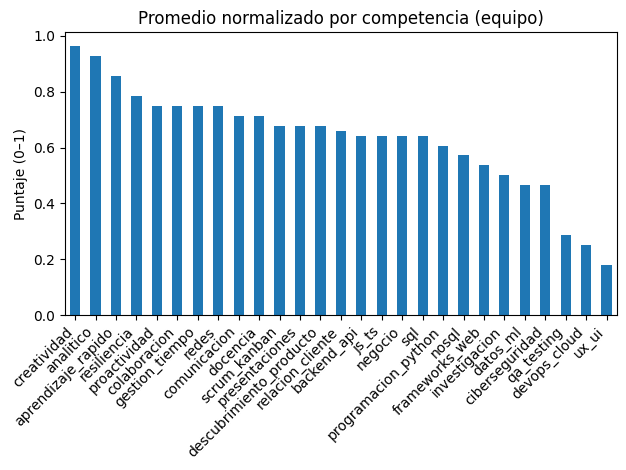

In [97]:

# (A) Promedios de competencias por grupo (equipo)
plt.figure()
team_means.plot(kind='bar')
plt.title('Promedio normalizado por competencia (equipo)')
plt.ylabel('Puntaje (0–1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'grafico_promedio_equipo.png'))
plt.show()


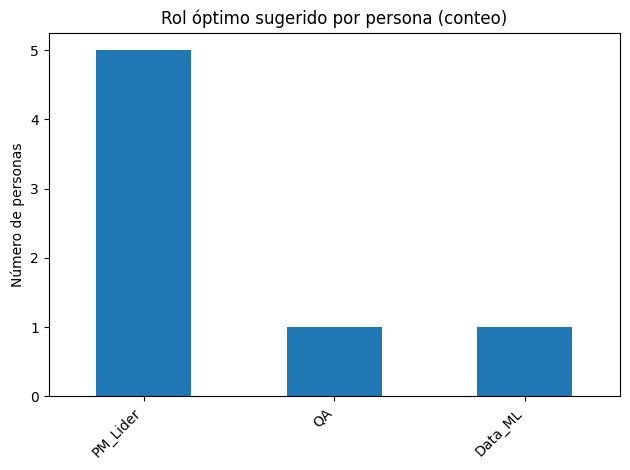

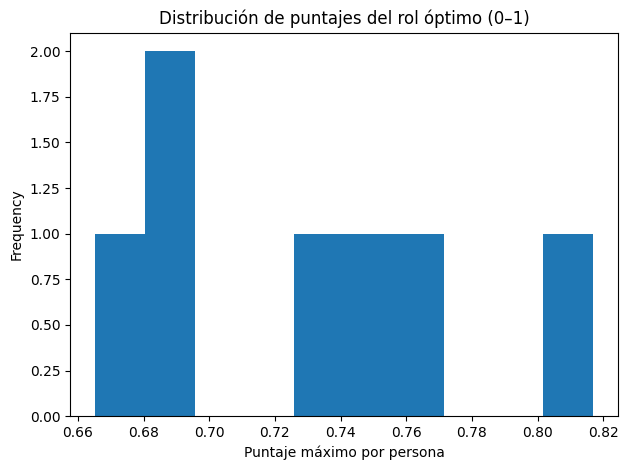

In [98]:

# (B) Role-fit por persona (máximo y distribución)
best_role = role_fit_df.idxmax(axis=1)
best_role_score = role_fit_df.max(axis=1)

# Conteo de rol óptimo
counts = best_role.value_counts()

plt.figure()
counts.plot(kind='bar')
plt.title('Rol óptimo sugerido por persona (conteo)')
plt.ylabel('Número de personas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'grafico_rol_optimo_conteo.png'))
plt.show()

# Distribución de puntajes máximos
plt.figure()
best_role_score.plot(kind='hist', bins=10)
plt.title('Distribución de puntajes del rol óptimo (0–1)')
plt.xlabel('Puntaje máximo por persona')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'grafico_distribucion_puntajes_maximos.png'))
plt.show()


In [99]:

# (C) Top-3 fortalezas por persona (tabla exportada y ejemplo mostrado)
top3 = scores_df.apply(lambda r: r.sort_values(ascending=False).head(3).index.tolist(), axis=1)
top3_df = pd.DataFrame({'Nombre': scores_df.index, 'Top3_Fortalezas': top3.values})
top3_df.to_csv(os.path.join(OUTPUT_DIR, 'top3_fortalezas_por_persona.csv'), encoding='utf-8', index=False)
display(top3_df)


Nombre  \
0     Katie Lai Yin Chiu Vásquez    
1  Eduin Ramón Chavarría Machado    
2     Jackyr Antonio Discua Calix   
3   Heysser Javier Machado Mejía    
4                 Lester Bustillo   
5       Erick David Blanco Santos   
6        Lizzy Pamela Mejia Mejia   

                                     Top3_Fortalezas  
0        [backend_api, gestion_tiempo, comunicacion]  
1   [redes, descubrimiento_producto, presentaciones]  
2                                [js_ts, redes, sql]  
3       [docencia, relacion_cliente, presentaciones]  
4    [creatividad, negocio, descubrimiento_producto]  
5  [programacion_python, colaboracion, comunicacion]  
6          [resiliencia, proactividad, scrum_kanban]

## Resumen por persona (exportable)

In [100]:

summary_rows = []
for name in scores_df.index:
    row = {
        'Nombre': name,
        'LinkedIn': df.loc[df['__Nombre'] == name, '__LinkedIn'].values[0] if '__LinkedIn' in df else '',
        'Rol_optimo': best_role.loc[name] if name in best_role.index else '',
        'Puntaje_rol_optimo': float(best_role_score.loc[name]) if name in best_role_score.index else np.nan,
        'Top3': ', '.join(top3_df.loc[top3_df['Nombre'] == name, 'Top3_Fortalezas'].values[0]) if name in top3_df['Nombre'].values else '',
        'Debilidades_texto': df.loc[df['__Nombre'] == name, '__Debilidades'].values[0] if '__Debilidades' in df else '',
        'Amenazas_texto': df.loc[df['__Nombre'] == name, '__Amenazas'].values[0] if '__Amenazas' in df else '',
        'Sugerencias': '; '.join(recs_df.loc[recs_df['Nombre'] == name, 'Sugerencias_capacitacion'].values[0]) if name in recs_df['Nombre'].values else ''
    }
    summary_rows.append(row)

person_df = pd.DataFrame(summary_rows)
person_df.to_csv(os.path.join(OUTPUT_DIR, 'resumen_persona.csv'), encoding='utf-8', index=False)
display(person_df)


Nombre  \
0     Katie Lai Yin Chiu Vásquez    
1  Eduin Ramón Chavarría Machado    
2     Jackyr Antonio Discua Calix   
3   Heysser Javier Machado Mejía    
4                 Lester Bustillo   
5       Erick David Blanco Santos   
6        Lizzy Pamela Mejia Mejia   

                                            LinkedIn Rol_optimo  \
0          https://www.linkedin.com/in/katielai-chiu   PM_Lider   
1  https://www.linkedin.com/in/eduin-ramon-chavar...   PM_Lider   
2              https://www.linkedin.com/in/jackyr-dc   PM_Lider   
3  https://www.linkedin.com/in/heysser-javier-mac...   PM_Lider   
4  https://www.linkedin.com/in/lester-bustillo-b8...         QA   
5  https://www.linkedin.com/in/erick-david-blanco...    Data_ML   
6  https://www.linkedin.com/in/lizzy-pamela-mejia...   PM_Lider   

   Puntaje_rol_optimo                                             Top3  \
0            0.727679        backend_api, gestion_tiempo, comunicacion   
1            0.665179   redes, descubrimiento_producto, presentaciones   
2            0.816964                                js_ts, redes, sql   
3            0.683036       docencia, relacion_cliente, presentaciones   
4            0.689394    creatividad, negocio, descubrimiento_producto   
5            0.743590  programacion_python, colaboracion, comunicacion   
6            0.767857          resiliencia, proactividad, scrum_kanban   

                                   Debilidades_texto  \
0    Horas de clase y los fines de semana el trabajo   
1                                     Procastinación   
2  Tiempo\nRecursos económicos\nDemasiadas áreas ...   
3  Procrastinación \nAveces necesito que me guíen...   
4  Me limita la falta de experiencia práctica en ...   
5  -\tNivel básico en el diseño y manejo de bases...   
6  Riesgo de dispersión y sobrecarga: muchos fren...   

                                      Amenazas_texto  \
0                            Ansiedad, enfermedades    
1  Disponibilidad de recursos como electricidad o...   
2  Estabilidad económica familiar\nPolítica nacional   
3  Redes sociales\nTener demasiado tiempo libre \...   
4  La alta competencia en el campo de la ingenier...   
5  -\tCambios rápidos en tecnologías frontend/bac...   
6  Alta competencia internacional por roles de da...   

                                         Sugerencias  
0  Ciencia de datos con Python (Pandas, scikit-le...  
1  Ciencia de datos con Python (Pandas, scikit-le...  
2  Ciberseguridad aplicada (OWASP Top 10, hardeni...  
3  Comunicación y presentaciones técnicas (storyt...  
4  Ciberseguridad aplicada (OWASP Top 10, hardeni...  
5  Ciberseguridad aplicada (OWASP Top 10, hardeni...  
6  Ciberseguridad aplicada (OWASP Top 10, hardeni...

## Comentario crítico automático

In [101]:

# Generar un breve diagnóstico textual basado en medias y brechas
def narrative_from_summary(summary_df, top_n=3):
    strengths = summary_df.head(top_n).index.tolist()
    gaps = summary_df.tail(top_n).index.tolist()
    text = []
    text.append('Fortalezas colectivas principales: ' + ', '.join(strengths) + '.')
    text.append('Brechas colectivas críticas: ' + ', '.join(gaps) + '.')
    text.append('Recomendación de foco inmediato: priorizar 1–2 brechas técnicas y 1 habilidad adaptativa.')
    return ' '.join(text)

diagnostico = narrative_from_summary(summary)
print(diagnostico)

with open(os.path.join(OUTPUT_DIR, 'diagnostico_equipo.txt'), 'w', encoding='utf-8') as f:
    f.write(diagnostico)


Fortalezas colectivas principales: creatividad, analitico, aprendizaje_rapido. Brechas colectivas críticas: qa_testing, devops_cloud, ux_ui. Recomendación de foco inmediato: priorizar 1–2 brechas técnicas y 1 habilidad adaptativa.


## Insight crítico de equipo (brechas y fortalezas)

In [102]:
# Promedios por grupo (equipo) y top fortalezas/brechas
team_means = scores_df.mean(axis=0).sort_values(ascending=False)
team_stds  = scores_df.std(axis=0).sort_values(ascending=False)

summary = pd.DataFrame({
    'media_equipo': team_means,
    'dispersion_std': team_stds
}).sort_values('media_equipo', ascending=False)

summary.to_csv(os.path.join(OUTPUT_DIR, 'resumen_equipo_por_grupo.csv'), encoding='utf-8')

print('--- Top 5 fortalezas del equipo ---')
print(summary.head(5))
print('\n--- Top 5 brechas del equipo ---')
print(summary.tail(5))
summary.head(10)

--- Top 5 fortalezas del equipo ---
                    media_equipo  dispersion_std
creatividad             0.964286        0.094491
analitico               0.928571        0.121988
aprendizaje_rapido      0.857143        0.133631
resiliencia             0.785714        0.172516
colaboracion            0.750000        0.204124

--- Top 5 brechas del equipo ---
                media_equipo  dispersion_std
ciberseguridad      0.464286        0.224934
datos_ml            0.464286        0.224934
qa_testing          0.285714        0.267261
devops_cloud        0.250000        0.250000
ux_ui               0.178571        0.237797


media_equipo  dispersion_std
creatividad             0.964286        0.094491
analitico               0.928571        0.121988
aprendizaje_rapido      0.857143        0.133631
resiliencia             0.785714        0.172516
colaboracion            0.750000        0.204124
gestion_tiempo          0.750000        0.144338
redes                   0.750000        0.204124
proactividad            0.750000        0.204124
comunicacion            0.714286        0.224934
docencia                0.714286        0.336296

In [103]:
debilidades_text = {}
amenazas_text = {}

for index, row in df.iterrows():
    name = row['__Nombre']
    debilidades_text[name] = row['__Debilidades']
    amenazas_text[name] = row['__Amenazas']

print("Debilidades extraidas por cada participante:")
for name, text in debilidades_text.items():
    print(f"{name}: {text}")

print("\nAmenazas extraidas por cada participante:")
for name, text in amenazas_text.items():
    print(f"{name}: {text}")

Debilidades extraidas por cada participante:
Katie Lai Yin Chiu Vásquez : Horas de clase y los fines de semana el trabajo
Eduin Ramón Chavarría Machado : Procastinación
Jackyr Antonio Discua Calix: Tiempo
Recursos económicos
Demasiadas áreas de interés 
Heysser Javier Machado Mejía : Procrastinación 
Aveces necesito que me guíen para poder avanzar
Aveces puedo ser demasiado expresivo al momento de comunicarme.
Lester Bustillo: Me limita la falta de experiencia práctica en proyectos reales y el manejo del tiempo entre estudios y trabajo.
A veces me cuesta mantener una rutina constante de estudio fuera de las clases.
También necesito fortalecer mis habilidades de comunicación profesional para expresar mejor mis ideas técnicas.
Erick David Blanco Santos: -	Nivel básico en el diseño y manejo de bases de datos relacionales.
-	Baja participación en discusiones grupales o presentaciones por inseguridad o falta de práctica en habilidades comunicativas.
-	Habilidades sociales limitadas en conte

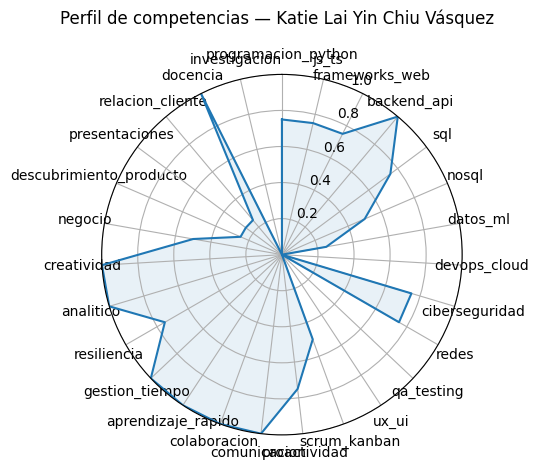

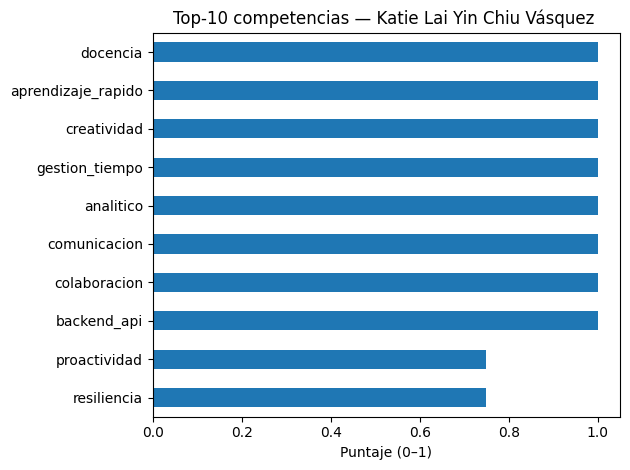

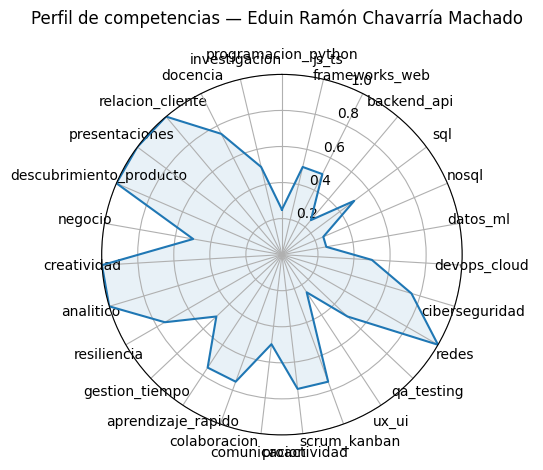

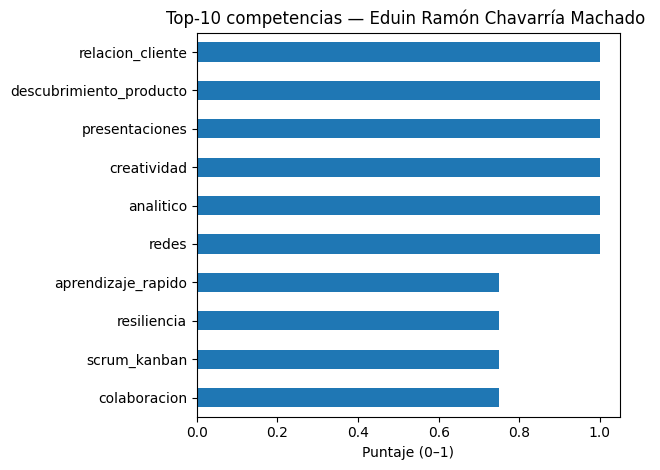

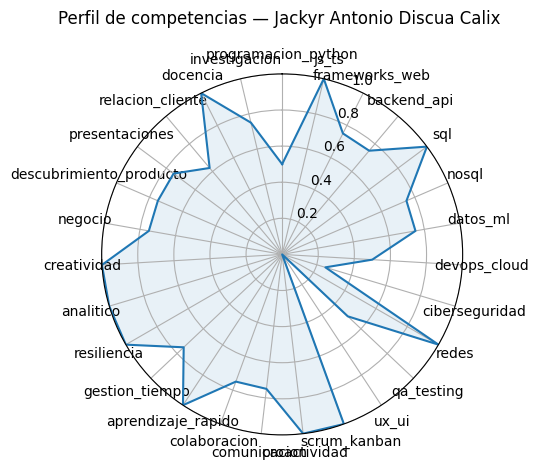

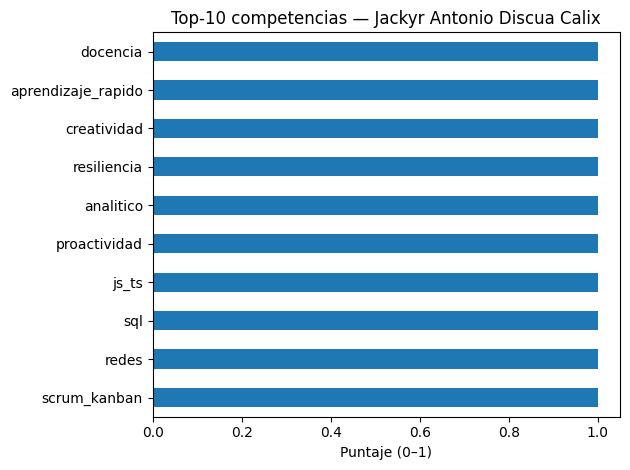

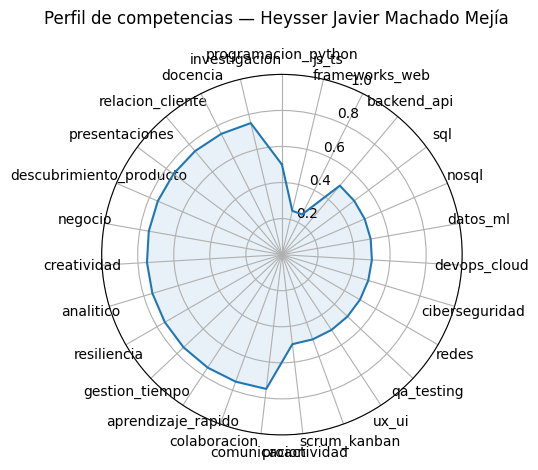

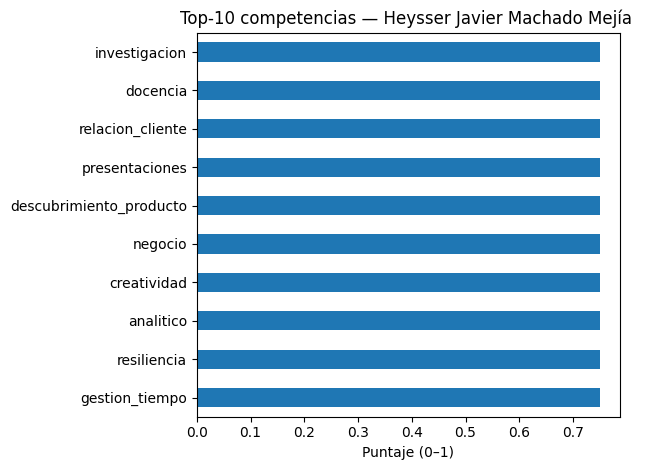

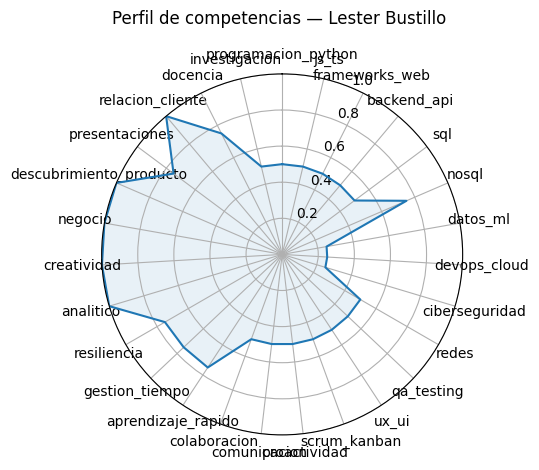

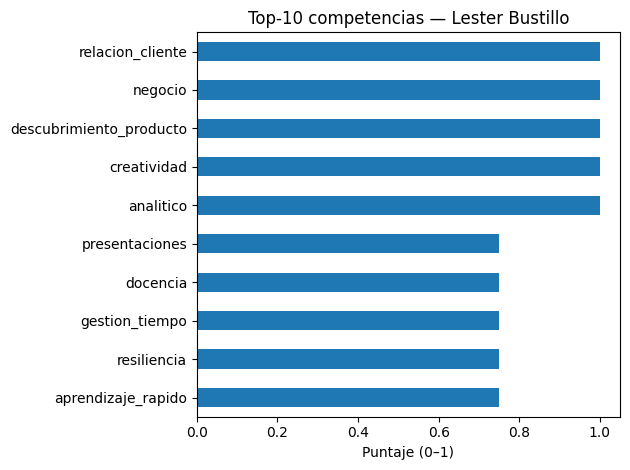

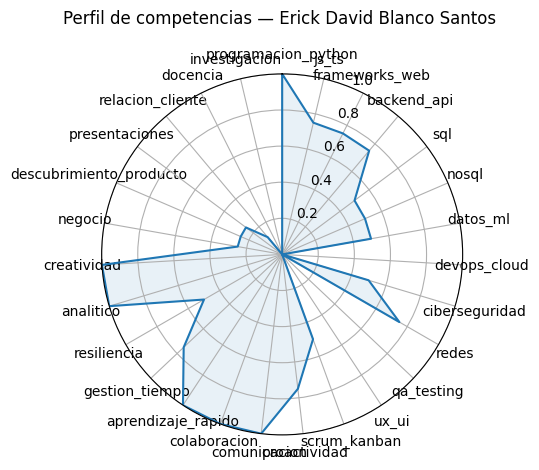

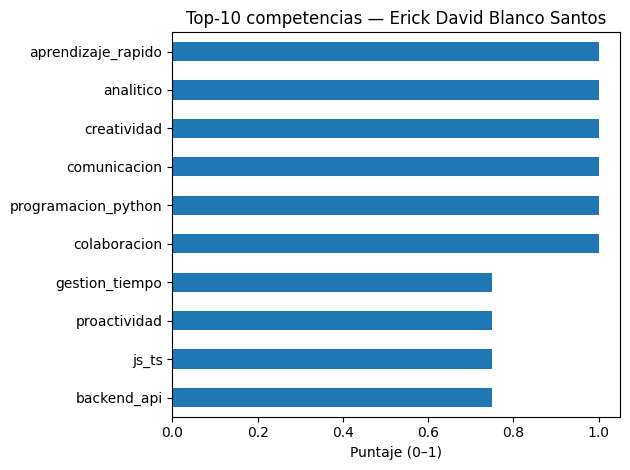

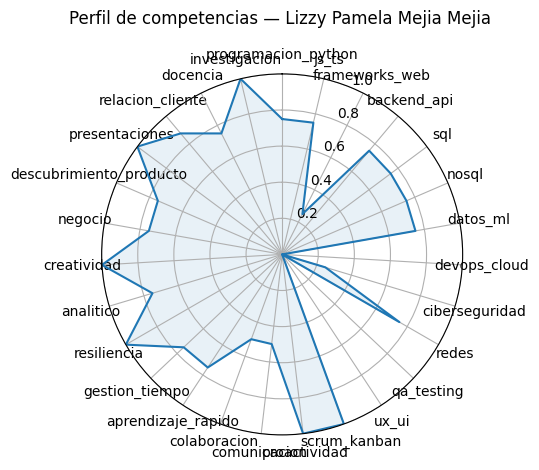

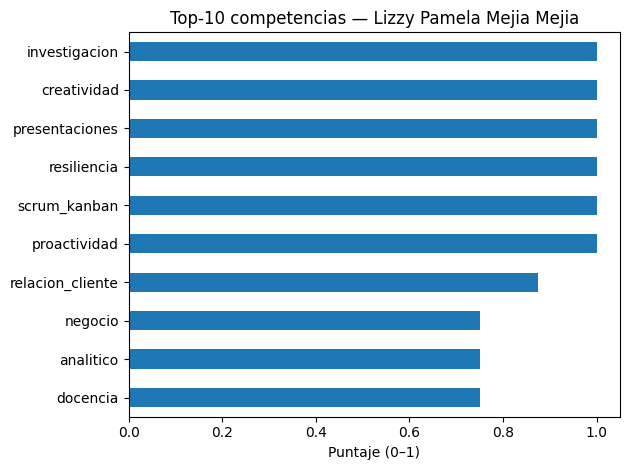

Listo. Diagramas en: /content/foda_output/personas


Nombre  \
0     Katie Lai Yin Chiu Vásquez    
1  Eduin Ramón Chavarría Machado    
2     Jackyr Antonio Discua Calix   
3   Heysser Javier Machado Mejía    
4                 Lester Bustillo   

                                               Radar  \
0  /content/foda_output/personas/Katie Lai Yin Ch...   
1  /content/foda_output/personas/Eduin Ramón Chav...   
2  /content/foda_output/personas/Jackyr Antonio D...   
3  /content/foda_output/personas/Heysser Javier M...   
4  /content/foda_output/personas/Lester Bustillo_...   

                                              Barras  
0  /content/foda_output/personas/Katie Lai Yin Ch...  
1  /content/foda_output/personas/Eduin Ramón Chav...  
2  /content/foda_output/personas/Jackyr Antonio D...  
3  /content/foda_output/personas/Heysser Javier M...  
4  /content/foda_output/personas/Lester Bustillo_...

In [104]:
# ===== Celda 3: Diagramas personales (radar + barras) =====
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Verificaciones mínimas
required = ['df','scores_df','role_fit_df']
for var in required:
    if var not in globals():
        raise SystemExit(f"Falta {var}. Ejecuta primero las celdas de Carga y Análisis.")

BASE_DIR = "/content/foda_output/personas"
os.makedirs(BASE_DIR, exist_ok=True)

# Lista de competencias (columnas de scores_df)
competencias = list(scores_df.columns)

def radar_chart(valores, etiquetas, titulo, path_png):
    # Preparar ángulos
    N = len(valores)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    valores_c = np.concatenate((valores, [valores[0]]))
    angles_c  = np.concatenate((angles,  [angles[0]]))

    plt.figure()
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(angles * 180/np.pi, etiquetas)
    ax.set_ylim(0, 1)
    ax.plot(angles_c, valores_c)
    ax.fill(angles_c, valores_c, alpha=0.1)  # sin color explícito
    plt.title(titulo)
    plt.tight_layout()
    plt.savefig(path_png, dpi=150)
    plt.show()

def barras_top_n(series, n, titulo, path_png):
    s = series.dropna().sort_values(ascending=True).tail(n)  # ascendente para barras horizontales
    plt.figure()
    s.plot(kind='barh')
    plt.xlabel("Puntaje (0–1)")
    plt.title(titulo)
    plt.tight_layout()
    plt.savefig(path_png, dpi=150)
    plt.show()

generados = []
for nombre in scores_df.index:
    fila = scores_df.loc[nombre]
    vals = fila.values.astype(float)
    # Radar de todas las competencias (si son demasiadas, se puede filtrar)
    radar_png = os.path.join(BASE_DIR, f"{nombre}_radar.png")
    radar_chart(vals, competencias, f"Perfil de competencias — {nombre} \n\n", radar_png)

    # Barras top-10
    barras_png = os.path.join(BASE_DIR, f"{nombre}_top10.png")
    barras_top_n(fila, 10, f"Top-10 competencias — {nombre}", barras_png)

    generados.append((nombre, radar_png, barras_png))

print(f"Listo. Diagramas en: {BASE_DIR}")
pd.DataFrame(generados, columns=["Nombre","Radar","Barras"]).head()


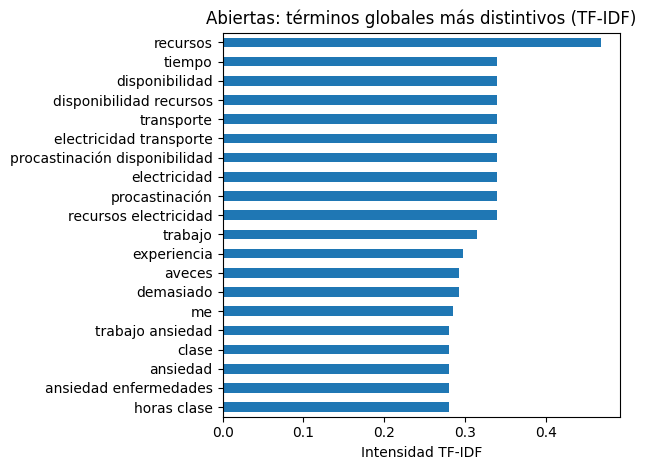

Listo. CSV de términos por persona y gráfico global guardados en /content/foda_output


In [105]:
# ===== Celda 4: Abiertas -> términos clave por persona y global =====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

if 'df' not in globals() or '__Debilidades' not in df.columns and '__Amenazas' not in df.columns:
    raise SystemExit("No encuentro columnas de abiertas (__Debilidades/__Amenazas). Revisa el mapeo en la celda 2.")

# Construir texto por persona (incluye fortalezas/oportunidades si existen)
posibles_cols = ['__Debilidades','__Amenazas','__Fortalezas','__Oportunidades']
cols_abiertas = [c for c in posibles_cols if c in df.columns]
if not cols_abiertas:
    cols_abiertas = ['__Debilidades','__Amenazas']  # mínimo

def unir_texto(row, cols):
    return " ".join([str(row.get(c,"")) for c in cols if c in row])

textos = df.set_index('__Nombre').apply(lambda r: unir_texto(r, cols_abiertas), axis=1)

# Stopwords español básicas (puedes ampliar esta lista)
stop_es = set("""
de la los las y en el un una para por con sin sobre entre hacia según segun que qué cual cuales como
más mas menos muy ya aún aun también tambien pero sino si no porque donde cuando mientras hasta desde
antes después despues durante contra sobre bajo sobre tras fueron fue han hay ser es son soy eres somos
sido estar estoy estamos está están estan estaba estaban este esta estos estas ese esa esos esas eso eso
""".split())

# TF-IDF (ngramas 1-2, min_df=1)
vectorizer = TfidfVectorizer(lowercase=True, stop_words=list(stop_es), ngram_range=(1,2), min_df=1)
X = vectorizer.fit_transform(textos.fillna(""))
vocab = np.array(vectorizer.get_feature_names_out())

# Top términos por persona
topk = 8
filas = []
for i, nombre in enumerate(textos.index):
    row = X[i].toarray().ravel()
    idx = row.argsort()[-topk:][::-1]
    terms = vocab[idx]
    vals  = row[idx]
    filas.append({"Nombre": nombre, "Top_terminos": ", ".join(terms)})

clave_persona_df = pd.DataFrame(filas)
clave_persona_df.to_csv("/content/foda_output/abiertas_top_terminos_por_persona.csv", index=False, encoding='utf-8')
clave_persona_df.head()

# Ranking global de términos (suma TF-IDF)
suma = np.asarray(X.sum(axis=0)).ravel()
orden = suma.argsort()[::-1]
top_global = pd.Series(suma[orden], index=vocab[orden])

# Gráfica de términos globales (top 20)
plt.figure()
top_global.head(20)[::-1].plot(kind='barh')  # horizontal (de menor a mayor para lectura)
plt.title("Abiertas: términos globales más distintivos (TF-IDF)")
plt.xlabel("Intensidad TF-IDF")
plt.tight_layout()
plt.savefig("/content/foda_output/abiertas_top_global.png", dpi=150)
plt.show()

print("Listo. CSV de términos por persona y gráfico global guardados en /content/foda_output")

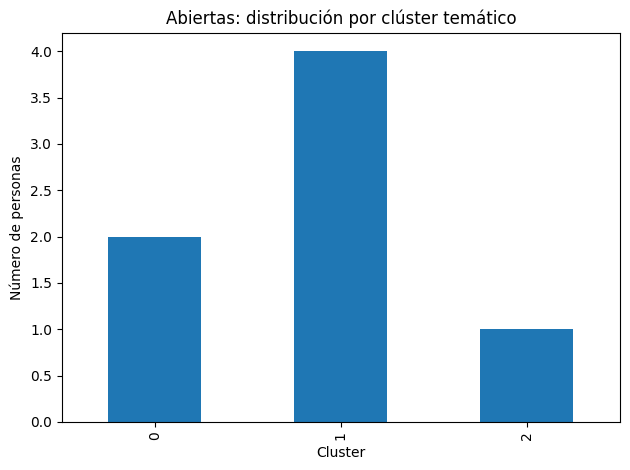

Clustering temático generado. Archivos en /content/foda_output


In [106]:
# ===== Celda 5: Clustering temático (K-Means) sobre abiertas =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Usamos los mismos 'textos' de la celda anterior; si no existen, los reconstruimos rápido:
if 'textos' not in globals():
    def unir_texto(row, cols):
        return " ".join([str(row.get(c,"")) for c in cols if c in row])
    posibles_cols = ['__Debilidades','__Amenazas','__Fortalezas','__Oportunidades']
    cols_abiertas = [c for c in posibles_cols if c in df.columns]
    if not cols_abiertas:
        cols_abiertas = ['__Debilidades','__Amenazas']
    textos = df.set_index('__Nombre').apply(lambda r: unir_texto(r, cols_abiertas), axis=1)

# Vectorizar (mismos parámetros de la celda 4 para consistencia)
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=1)
X = vectorizer.fit_transform(textos.fillna(""))

n_docs = X.shape[0]
k = min(3, n_docs) if n_docs >= 2 else 1  # evita fallos con muy pocos docs
k = max(k, 1)

km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(X)

clusters_df = pd.DataFrame({"Nombre": textos.index, "Cluster": labels})
clusters_df.to_csv("/content/foda_output/abiertas_clusters.csv", index=False, encoding='utf-8')
clusters_df.head()

# Conteo por clúster (gráfico)
conteo = clusters_df['Cluster'].value_counts().sort_index()
plt.figure()
conteo.plot(kind='bar')
plt.title("Abiertas: distribución por clúster temático")
plt.xlabel("Cluster")
plt.ylabel("Número de personas")
plt.tight_layout()
plt.savefig("/content/foda_output/abiertas_cluster_conteo.png", dpi=150)
plt.show()

print("Clustering temático generado. Archivos en /content/foda_output")


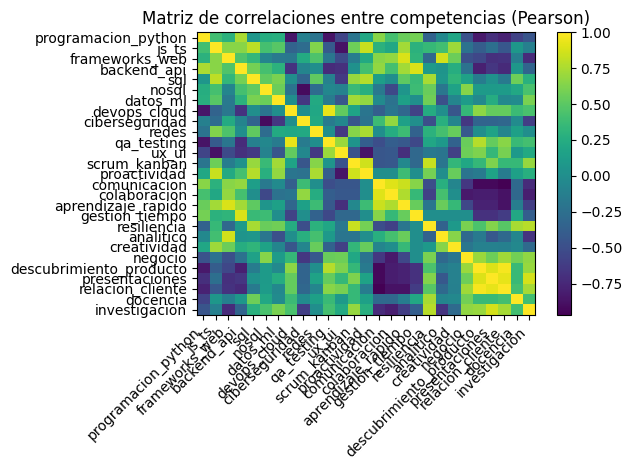

Correlaciones guardadas en /content/foda_output


In [107]:
# ===== Celda 6: Correlaciones entre competencias =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'scores_df' not in globals():
    raise SystemExit("Falta scores_df. Ejecuta la celda de Análisis primero.")

corr = scores_df.corr(method='pearson').fillna(0.0)
corr.to_csv("/content/foda_output/correlaciones_competencias.csv", encoding='utf-8')

plt.figure()
plt.imshow(corr, aspect='auto')
plt.title("Matriz de correlaciones entre competencias (Pearson)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.savefig("/content/foda_output/correlaciones_heatmap.png", dpi=150)
plt.show()

print("Correlaciones guardadas en /content/foda_output")


In [108]:
# ===== Celda 7: Reporte por persona =====
import os
import numpy as np
import pandas as pd

BASE_DIR = "/content/foda_output/personas"
os.makedirs(BASE_DIR, exist_ok=True)

# Preparar estructuras auxiliares
gaps_umbral = 0.5
brechas_por_persona = {}
for nombre in scores_df.index:
    fila = scores_df.loc[nombre]
    brechas = [c for c, v in fila.items() if not pd.isna(v) and v < gaps_umbral]
    brechas_por_persona[nombre] = brechas

# Mapeo rápido de términos clave por persona (desde celda 4)
clave_map = {}
try:
    clave_persona_df = pd.read_csv("/content/foda_output/abiertas_top_terminos_por_persona.csv")
    for _, r in clave_persona_df.iterrows():
        clave_map[r['Nombre']] = r['Top_terminos']
except Exception:
    # si no existe el archivo, dejamos vacío
    pass

# Recs ya existen en recs_df (Nombre, Sugerencias_capacitacion)
recs_map = {}
if 'recs_df' in globals():
    for _, r in recs_df.iterrows():
        recs_map[r['Nombre']] = "; ".join(r['Sugerencias_capacitacion']) if isinstance(r['Sugerencias_capacitacion'], (list, tuple)) else str(r['Sugerencias_capacitacion'])

# Top3 ya existe en top3_df (Nombre, Top3_Fortalezas)
top3_map = {}
if 'top3_df' in globals():
    for _, r in top3_df.iterrows():
        top3_map[r['Nombre']] = ", ".join(r['Top3_Fortalezas']) if isinstance(r['Top3_Fortalezas'], (list, tuple)) else str(r['Top3_Fortalezas'])

# Resumen maestro
rows = []
for nombre in scores_df.index:
    rol  = best_role.loc[nombre] if 'best_role' in globals() and nombre in best_role.index else ''
    rmax = float(best_role_score.loc[nombre]) if 'best_role_score' in globals() and nombre in best_role_score.index else np.nan
    top3 = top3_map.get(nombre, "")
    gaps = ", ".join(brechas_por_persona.get(nombre, []))
    recs = recs_map.get(nombre, "")
    terms = clave_map.get(nombre, "")

    # Rutas a imágenes
    radar_png = os.path.join(BASE_DIR, f"{nombre}_radar.png")
    barras_png = os.path.join(BASE_DIR, f"{nombre}_top10.png")

    # Texto del reporte
    report_txt = f"""Nombre: {nombre}
Rol óptimo sugerido: {rol} (puntaje: {rmax:.3f})
Top-3 fortalezas: {top3}
Brechas detectadas (<0.5): {gaps}
Sugerencias de capacitación: {recs}
Términos clave (abiertas): {terms}

Imágenes:
- Radar: {radar_png if os.path.exists(radar_png) else 'N/A'}
- Barras Top10: {barras_png if os.path.exists(barras_png) else 'N/A'}
"""
    out_path = os.path.join(BASE_DIR, f"{nombre}_reporte.txt")
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(report_txt)

    rows.append({
        "Nombre": nombre,
        "Rol_optimo": rol,
        "Puntaje_rol_optimo": rmax,
        "Top3": top3,
        "Brechas(<0.5)": gaps,
        "Sugerencias": recs,
        "Terminos_clave": terms,
        "Radar_png": radar_png if os.path.exists(radar_png) else "",
        "Barras_png": barras_png if os.path.exists(barras_png) else "",
        "Reporte_txt": out_path
    })

reporte_df = pd.DataFrame(rows)
reporte_df.to_csv("/content/foda_output/reportes_persona_consolidado.csv", index=False, encoding="utf-8")
print("Reportes individuales en:", BASE_DIR)
reporte_df.head()


Reportes individuales en: /content/foda_output/personas


Nombre Rol_optimo  Puntaje_rol_optimo  \
0     Katie Lai Yin Chiu Vásquez    PM_Lider            0.727679   
1  Eduin Ramón Chavarría Machado    PM_Lider            0.665179   
2     Jackyr Antonio Discua Calix   PM_Lider            0.816964   
3   Heysser Javier Machado Mejía    PM_Lider            0.683036   
4                 Lester Bustillo         QA            0.689394   

                                             Top3  \
0       backend_api, gestion_tiempo, comunicacion   
1  redes, descubrimiento_producto, presentaciones   
2                               js_ts, redes, sql   
3      docencia, relacion_cliente, presentaciones   
4   creatividad, negocio, descubrimiento_producto   

                                       Brechas(<0.5)  \
0  datos_ml, devops_cloud, qa_testing, ux_ui, des...   
1  programacion_python, backend_api, nosql, datos...   
2                              ciberseguridad, ux_ui   
3                              js_ts, frameworks_web   
4             datos_ml, devops_cloud, ciberseguridad   

                                         Sugerencias  \
0  Ciencia de datos con Python (Pandas, scikit-le...   
1  Ciencia de datos con Python (Pandas, scikit-le...   
2  Ciberseguridad aplicada (OWASP Top 10, hardeni...   
3  Comunicación y presentaciones técnicas (storyt...   
4  Ciberseguridad aplicada (OWASP Top 10, hardeni...   

                                      Terminos_clave  \
0  fines semana, trabajo ansiedad, ansiedad, sema...   
1  recursos electricidad, disponibilidad recursos...   
2  demasiadas, demasiadas áreas, tiempo recursos,...   
3  aveces, demasiado, procrastinación aveces, nec...   
4  mis, experiencia, me, buscan, campo, campo ing...   

                                           Radar_png  \
0  /content/foda_output/personas/Katie Lai Yin Ch...   
1  /content/foda_output/personas/Eduin Ramón Chav...   
2  /content/foda_output/personas/Jackyr Antonio D...   
3  /content/foda_output/personas/Heysser Javier M...   
4  /content/foda_output/personas/Lester Bustillo_...   

                                          Barras_png  \
0  /content/foda_output/personas/Katie Lai Yin Ch...   
1  /content/foda_output/personas/Eduin Ramón Chav...   
2  /content/foda_output/personas/Jackyr Antonio D...   
3  /content/foda_output/personas/Heysser Javier M...   
4  /content/foda_output/personas/Lester Bustillo_...   

                                         Reporte_txt  
0  /content/foda_output/personas/Katie Lai Yin Ch...  
1  /content/foda_output/personas/Eduin Ramón Chav...  
2  /content/foda_output/personas/Jackyr Antonio D...  
3  /content/foda_output/personas/Heysser Javier M...  
4  /content/foda_output/personas/Lester Bustillo_...

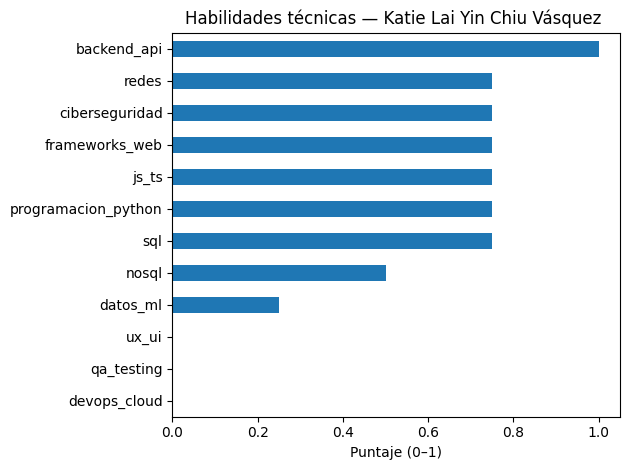

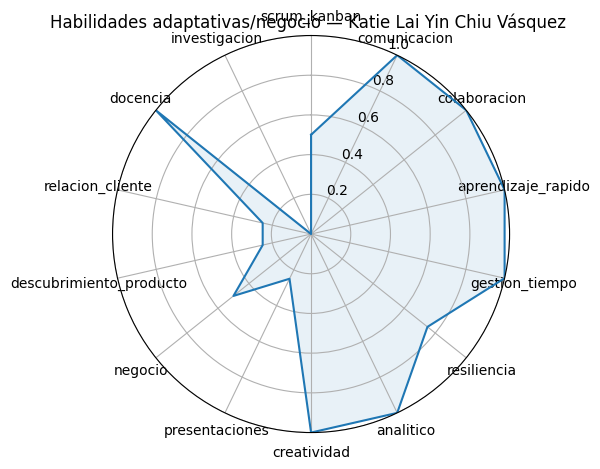

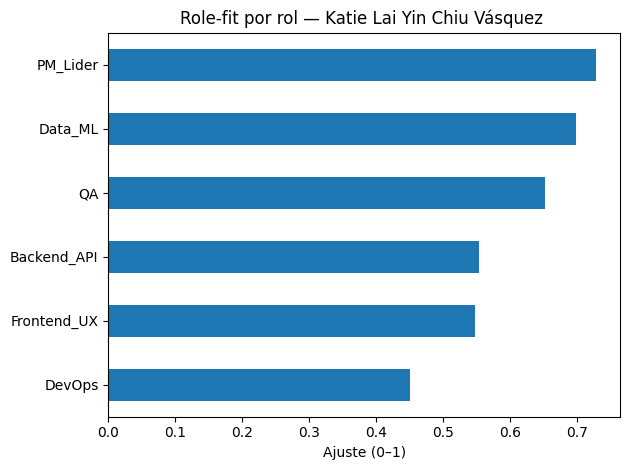

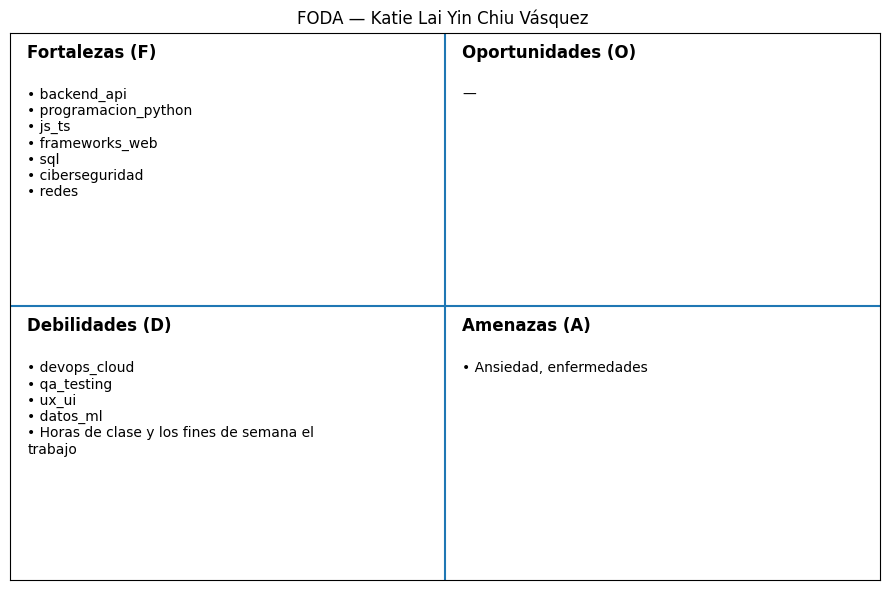

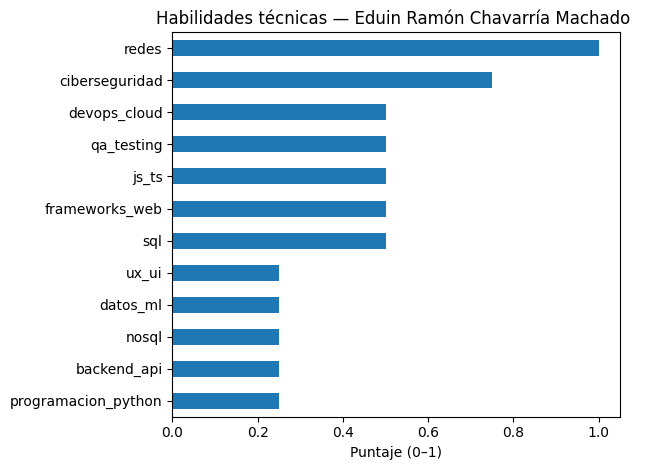

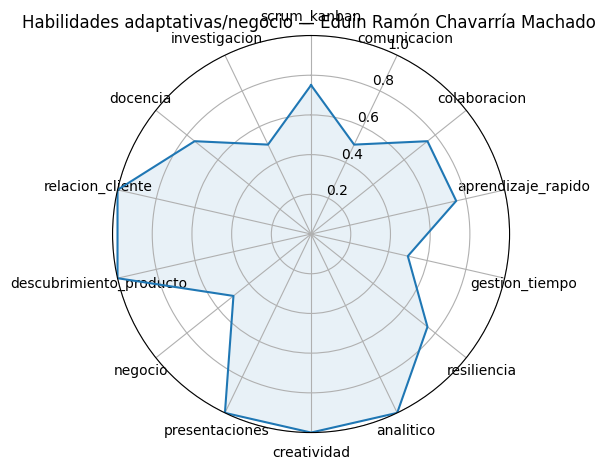

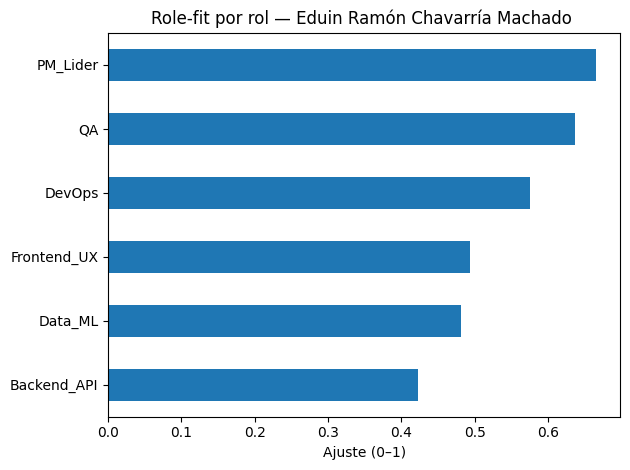

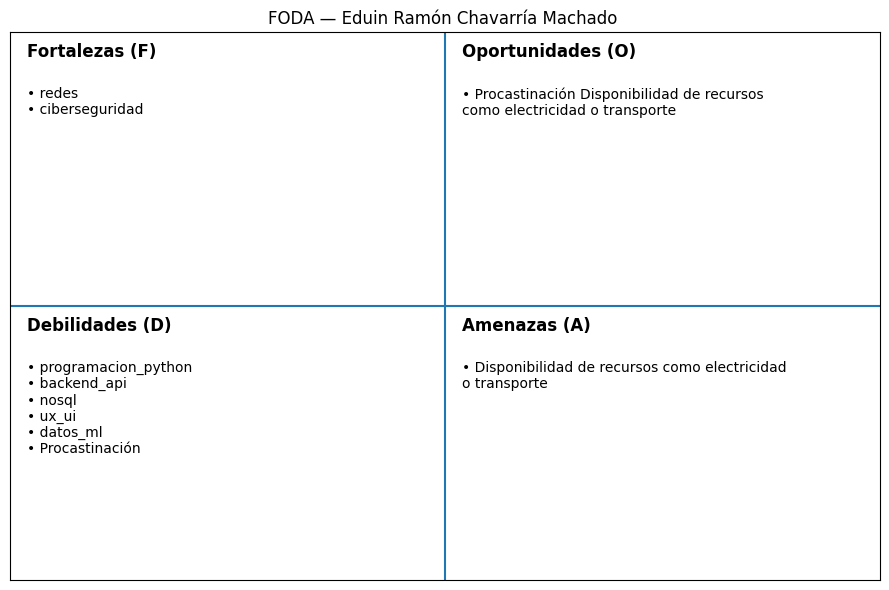

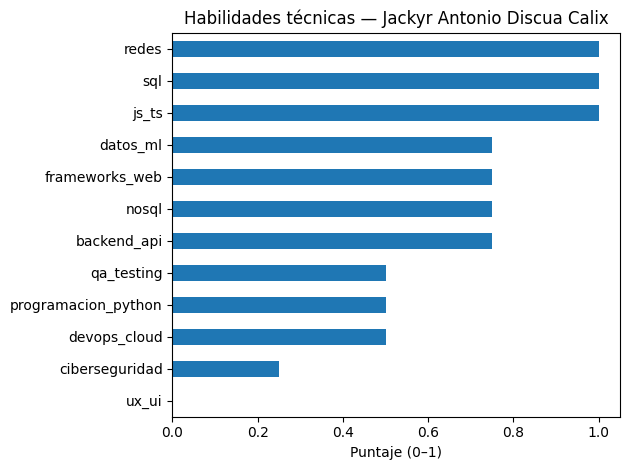

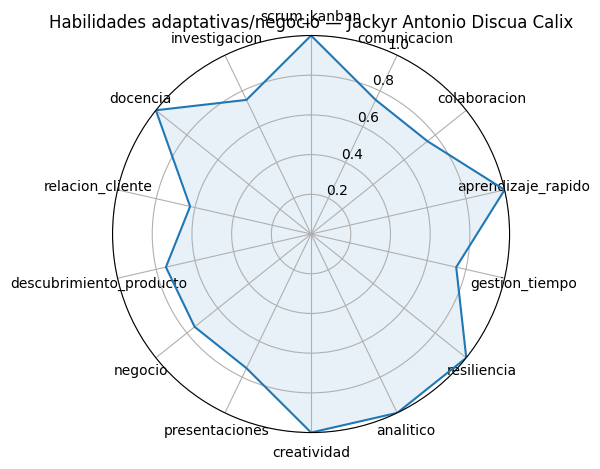

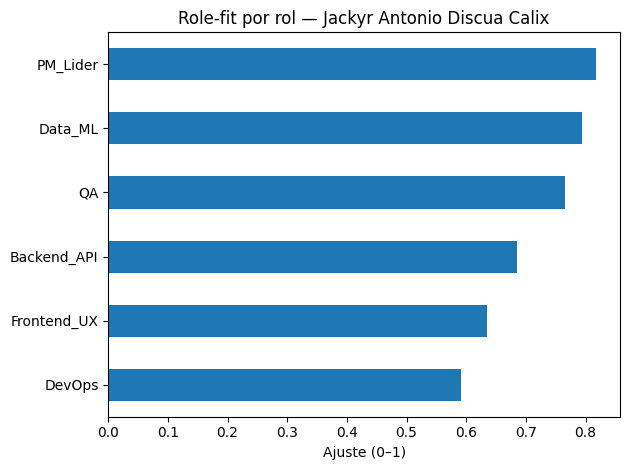

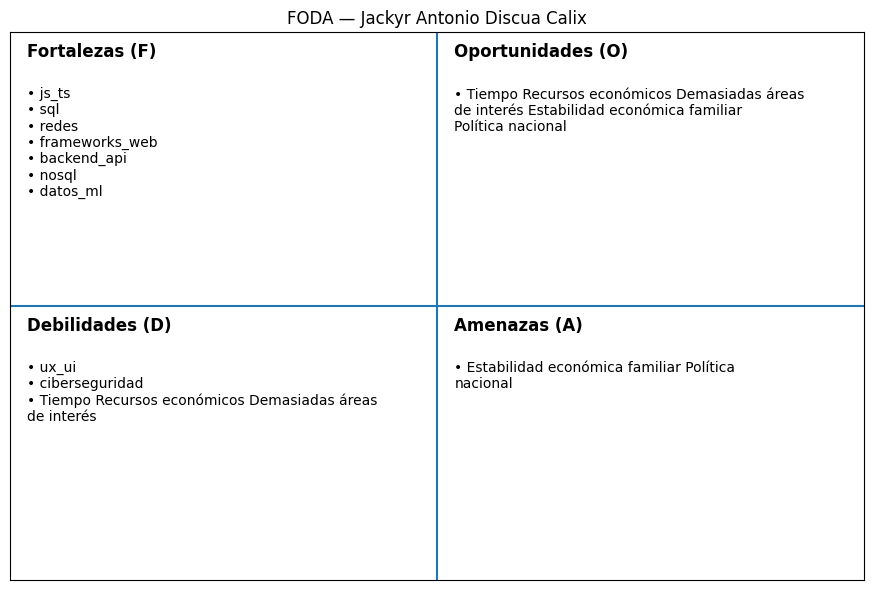

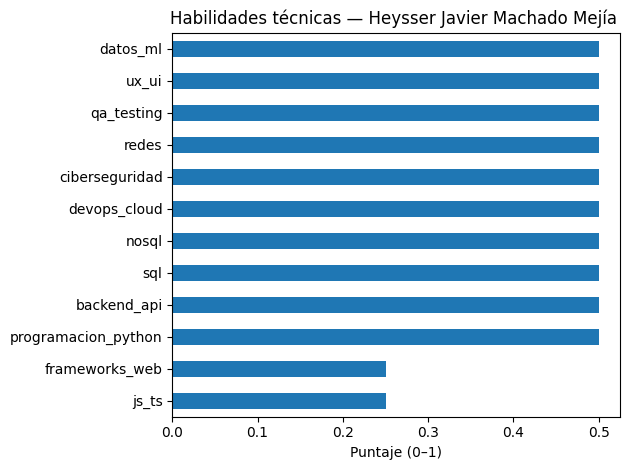

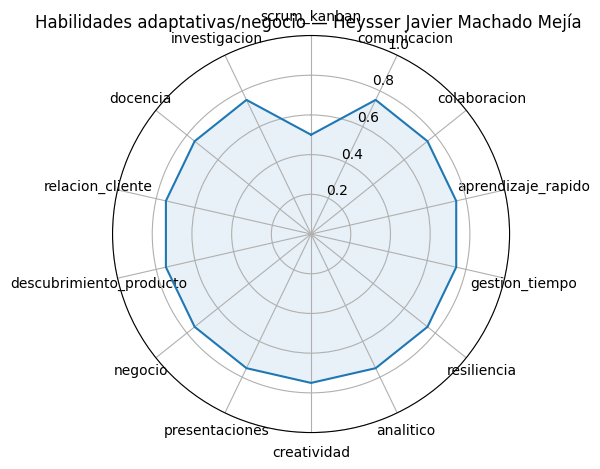

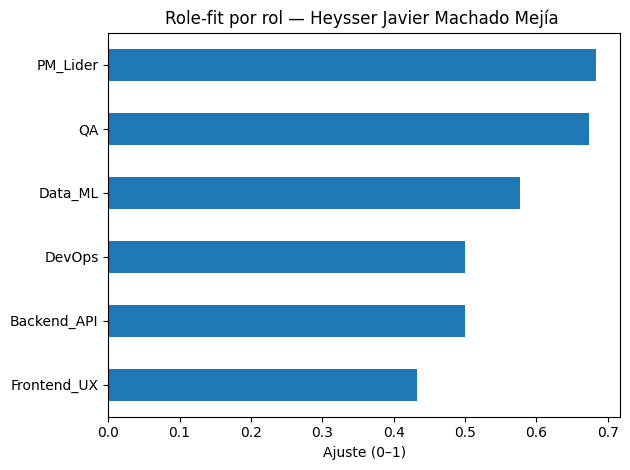

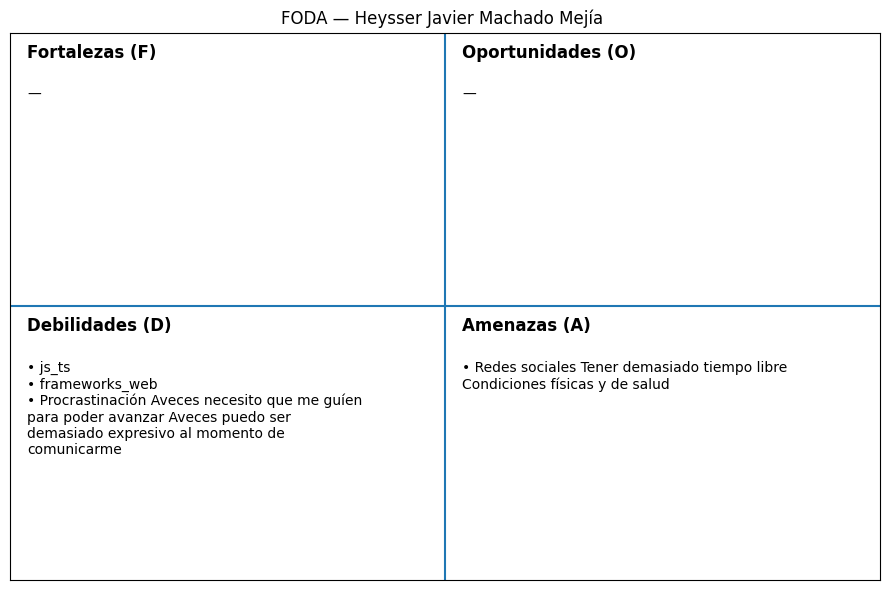

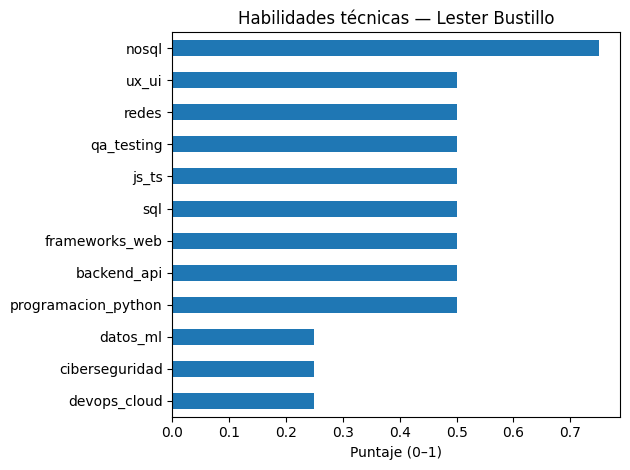

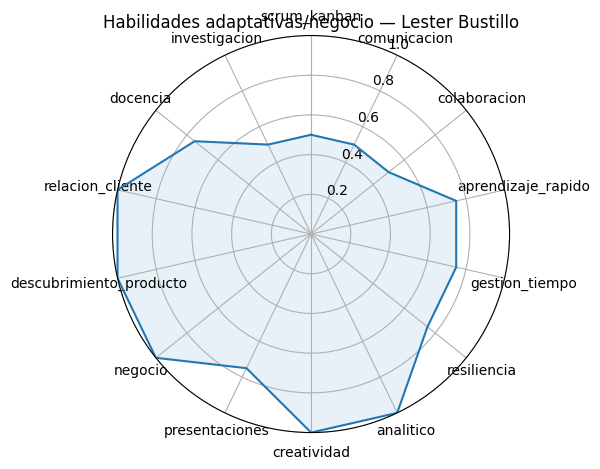

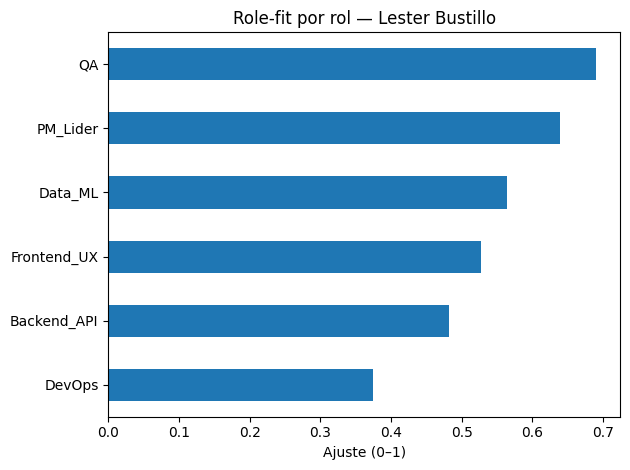

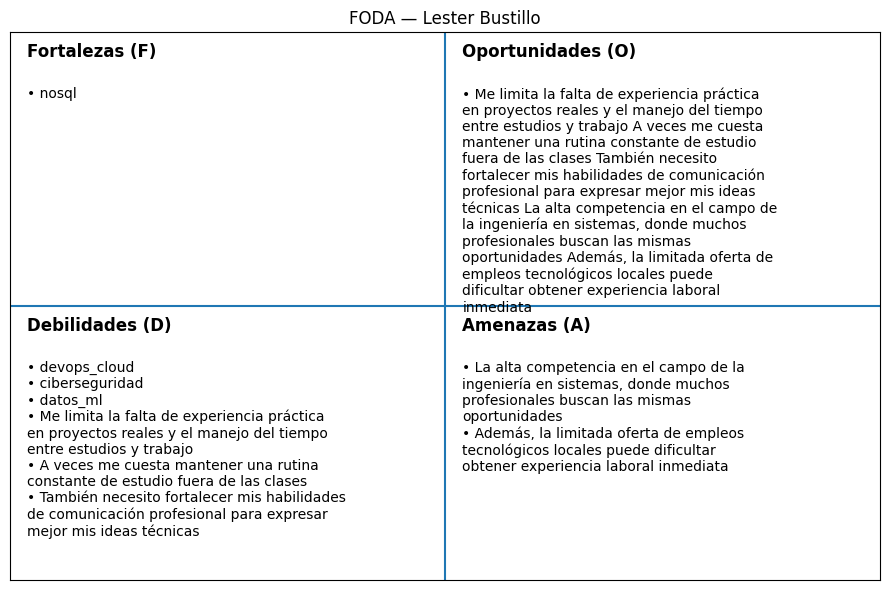

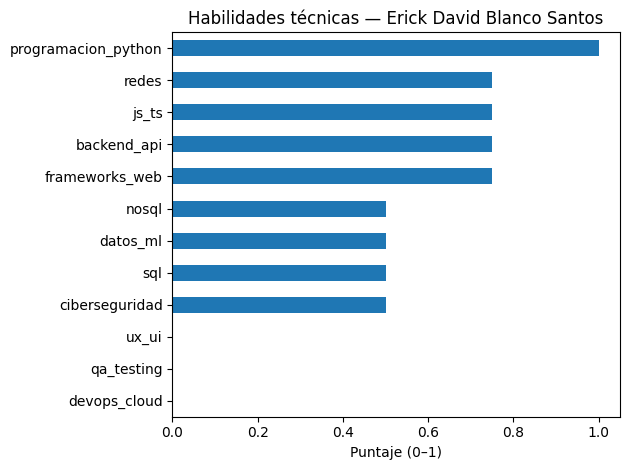

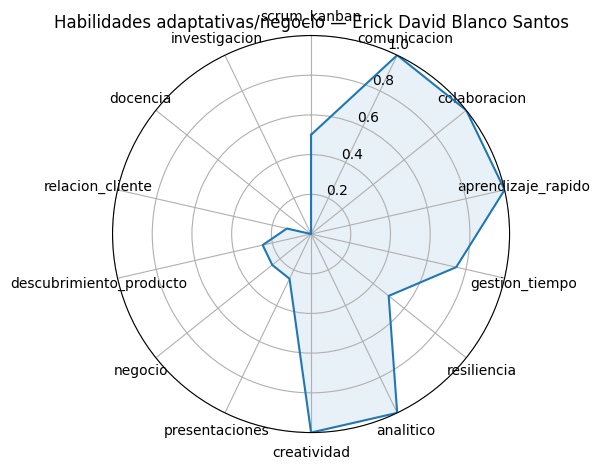

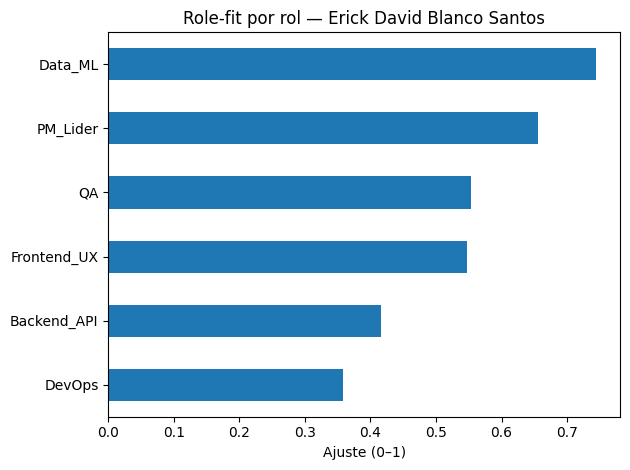

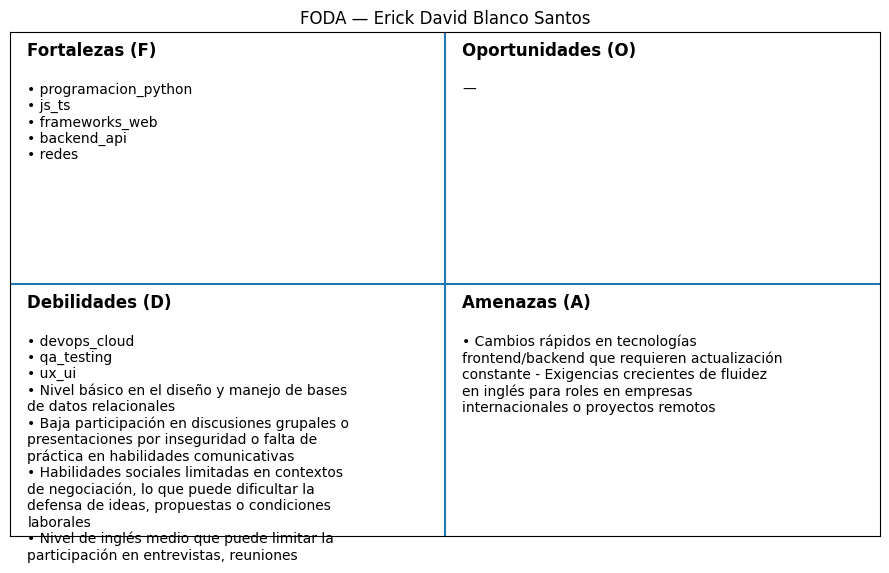

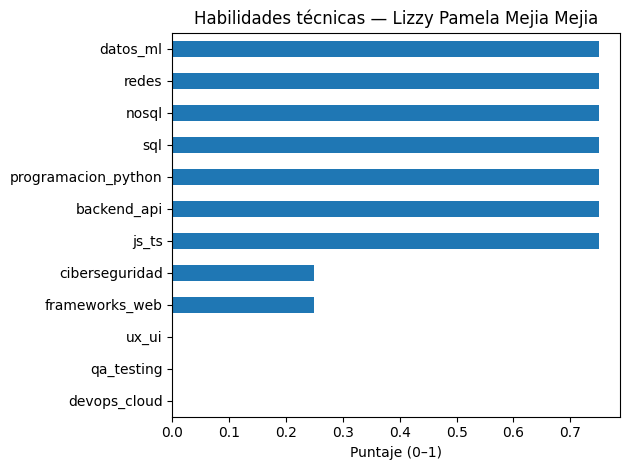

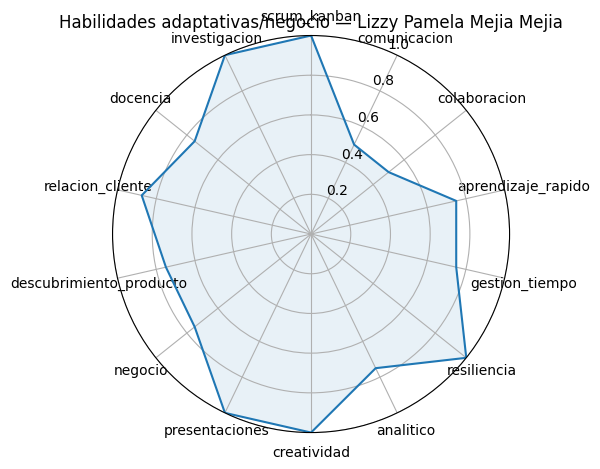

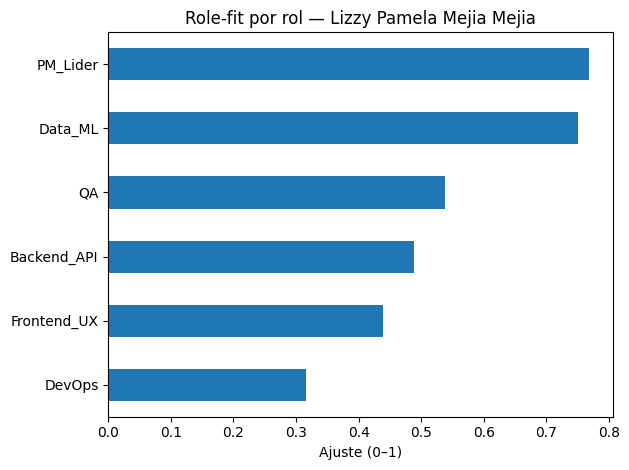

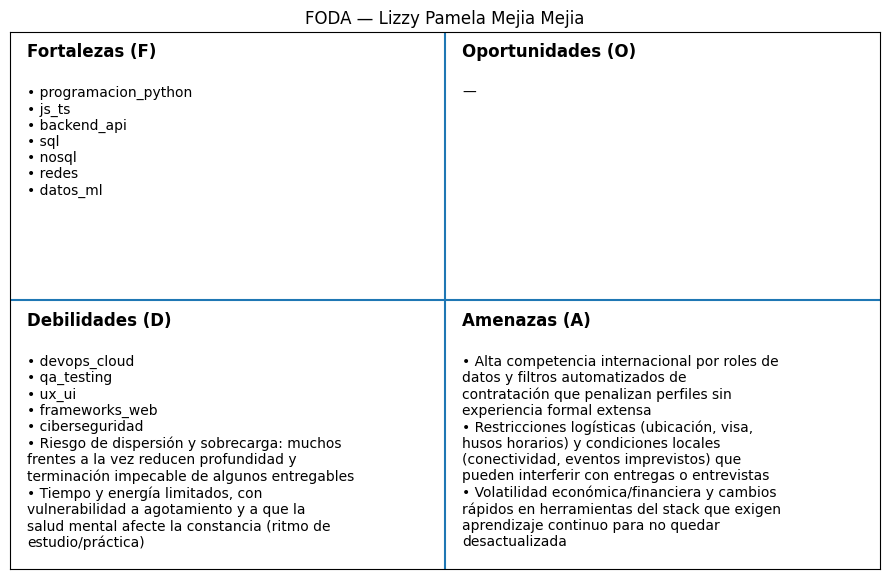

 Informes profundos por participante generados en: /content/foda_output/deep_persona


Nombre  Tecnico_promedio Rol_sugerido  Rol_puntaje  \
0     Katie Lai Yin Chiu Vásquez           0.520833     PM_Lider     0.727679   
1  Eduin Ramón Chavarría Machado           0.458333     PM_Lider     0.665179   
2     Jackyr Antonio Discua Calix          0.645833     PM_Lider     0.816964   
3   Heysser Javier Machado Mejía           0.458333     PM_Lider     0.683036   
4                 Lester Bustillo          0.458333           QA     0.689394   

                                          TopTecnico  \
0  backend_api(1.00); programacion_python(0.75); ...   
1     redes(1.00); ciberseguridad(0.75); js_ts(0.50)   
2                js_ts(1.00); sql(1.00); redes(1.00)   
3  programacion_python(0.50); backend_api(0.50); ...   
4  nosql(0.75); programacion_python(0.50); framew...   

                                     BrechasTecnicas  \
0  devops_cloud(0.00); qa_testing(0.00); ux_ui(0.00)   
1  programacion_python(0.25); backend_api(0.25); ...   
2  ux_ui(0.00); ciberseguridad(0.25); devops_clou...   
3  js_ts(0.25); frameworks_web(0.25); programacio...   
4  devops_cloud(0.25); ciberseguridad(0.25); dato...   

                                        PNG_Tecnicas  \
0  /content/foda_output/deep_persona/Katie Lai Yi...   
1  /content/foda_output/deep_persona/Eduin Ramón ...   
2  /content/foda_output/deep_persona/Jackyr Anton...   
3  /content/foda_output/deep_persona/Heysser Javi...   
4  /content/foda_output/deep_persona/Lester Busti...   

                                           PNG_Radar  \
0  /content/foda_output/deep_persona/Katie Lai Yi...   
1  /content/foda_output/deep_persona/Eduin Ramón ...   
2  /content/foda_output/deep_persona/Jackyr Anton...   
3  /content/foda_output/deep_persona/Heysser Javi...   
4  /content/foda_output/deep_persona/Lester Busti...   

                                         PNG_RoleFit  \
0  /content/foda_output/deep_persona/Katie Lai Yi...   
1  /content/foda_output/deep_persona/Eduin Ramón ...   
2  /content/foda_output/deep_persona/Jackyr Anton...   
3  /content/foda_output/deep_persona/Heysser Javi...   
4  /content/foda_output/deep_persona/Lester Busti...   

                                            PNG_FODA  \
0  /content/foda_output/deep_persona/Katie Lai Yi...   
1  /content/foda_output/deep_persona/Eduin Ramón ...   
2  /content/foda_output/deep_persona/Jackyr Anton...   
3  /content/foda_output/deep_persona/Heysser Javi...   
4  /content/foda_output/deep_persona/Lester Busti...   

                                         Informe_TXT  
0  /content/foda_output/deep_persona/Katie Lai Yi...  
1  /content/foda_output/deep_persona/Eduin Ramón ...  
2  /content/foda_output/deep_persona/Jackyr Anton...  
3  /content/foda_output/deep_persona/Heysser Javi...  
4  /content/foda_output/deep_persona/Lester Busti...

In [116]:
# ===== Celda: Informe profundo por participante =====

# ---------- Rutas / directorios ----------
OUT_DIR = "/content/foda_output/deep_persona"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Listas de competencias por categoría ----------
# Ajusta según los nombres reales de columnas en tu scores_df:
TECNICAS = [
    'programacion_python','js_ts','frameworks_web','backend_api','sql','nosql',
    'devops_cloud','ciberseguridad','redes','qa_testing','ux_ui','datos_ml'
]
ADAPT_Y_NEG = [
    'scrum_kanban','comunicacion','colaboracion','aprendizaje_rapido','gestion_tiempo','resiliencia',
    'analitico','creatividad','presentaciones','negocio','descubrimiento_producto','relacion_cliente',
    'docencia','investigacion','ingles'
]

# Filtra por las que realmente existan en tu data:
TECNICAS = [c for c in TECNICAS if c in scores_df.columns]
ADAPT_Y_NEG = [c for c in ADAPT_Y_NEG if c in scores_df.columns]

# ---------- Umbrales y parámetros ----------
TH_STRONG = 0.70   # >= 0.70 (≈ ≥ 4/5) => Fortaleza técnica clara
TH_WEAK   = 0.50   # <  0.50 (≈ < 3/5)  => Debilidad técnica clara
MAX_ITEMS_FODA = 7
TOPK_TERMS = 8     # términos TF-IDF por persona (si existe 'textos')

# ---------- Soporte abiertas ----------
cols_F = [c for c in ['__Fortalezas'] if c in df.columns]
cols_O = [c for c in ['__Oportunidades'] if c in df.columns]
cols_D = [c for c in ['__Debilidades'] if c in df.columns]
cols_A = [c for c in ['__Amenazas'] if c in df.columns]

LEXI_F = r"(fuerte|lider|liderazgo|experto|destaco|bueno|solido|sólido|domino|alto nivel)"
LEXI_O = r"(oportun|tendenc|curso|certific|aprovech|mentoria|mentoría|practic|beca|alianza|mercado)"
LEXI_D = r"(debil|me falta|poco|bajo|dificultad|no domino|me cuesta|limitaci|brecha)"
LEXI_A = r"(amenaz|riesgo|competenc|tiempo|presión|presion|recortes|falta de|dependenc|bloqueo)"

def limpiar_texto(x):
    s = str(x) if not pd.isna(x) else ""
    return re.sub(r"\s+", " ", s).strip()

def frases_abiertas(row, cols):
    if not cols:
        return []
    blob = " | ".join([limpiar_texto(row.get(c, "")) for c in cols])
    if not blob:
        return []
    partes = re.split(r"[;\.\n\|]+", blob)
    partes = [p.strip(" -•*") for p in partes if p.strip()]
    return partes

def inferir_desde_keywords(texto, regex):
    if not texto:
        return []
    if re.search(regex, texto.lower()):
        frag = re.split(r"[;\.\n\|]+", texto)
        frag = [f.strip(" -•*") for f in frag if f.strip()]
        return frag
    return []

# ---------- Palabras clave -> áreas de capacitación (para narrativa) ----------
G2AREA = {
    'backend_api': 'APIs REST con Node/Express y autenticación JWT',
    'sql': 'Modelado y consultas SQL (JOINs, índices, normalización)',
    'nosql': 'Diseño y operación de bases NoSQL',
    'devops_cloud': 'DevOps/Cloud (Docker, CI/CD, nube)',
    'ciberseguridad': 'Ciberseguridad aplicada (OWASP Top 10, hardening)',
    'redes': 'Redes (VLAN, routing/switching, troubleshooting)',
    'qa_testing': 'Pruebas y calidad (unit/integration, TDD, cobertura)',
    'ux_ui': 'Frontend/UX (patrones UI, heurísticas, handoff)',
    'js_ts': 'JavaScript/TypeScript moderno',
    'frameworks_web': 'Frameworks web (React/Angular/Vue)',
    'programacion_python': 'Python para ciencia de datos y automatización',
    'datos_ml': 'Ciencia de datos con Python (Pandas, scikit-learn, EDA)',
    'scrum_kanban': 'Gestión ágil (Scrum/Kanban)',
    'comunicacion': 'Comunicación y presentaciones técnicas',
    'colaboracion': 'Trabajo en equipo y resolución de conflictos',
    'aprendizaje_rapido': 'Aprendizaje efectivo (técnicas y proyectos guiados)',
    'gestion_tiempo': 'Gestión del tiempo y priorización',
    'resiliencia': 'Manejo del estrés y resiliencia',
    'analitico': 'Pensamiento analítico y resolución de problemas',
    'creatividad': 'Creatividad aplicada (design thinking, ideación)',
    'negocio': 'Fundamentos de negocio y métricas',
    'descubrimiento_producto': 'Descubrimiento de producto y research con usuarios',
    'presentaciones': 'Presentaciones técnicas y storytelling',
    'relacion_cliente': 'Experiencia de cliente/usuario',
    'docencia': 'Didáctica y técnicas de enseñanza',
    'investigacion': 'Métodos de investigación y redacción científica',
    'ingles': 'Inglés técnico aplicado',
}

# ---------- Role-fit: si no existen best_role/best_role_score, los calculamos aquí ----------
def role_fit_row(scores_row, weights):
    num = den = 0.0
    for g, w in weights.items():
        v = scores_row.get(g, np.nan)
        if not pd.isna(v):
            num += v*w
            den += w
    return num/den if den>0 else np.nan

if 'best_role' not in globals() or 'best_role_score' not in globals():
    # Pesos por rol (mismos que en la celda de análisis)
    ROLE_WEIGHTS = {
        'PM_Lider': {'comunicacion':1.0, 'colaboracion':0.8, 'gestion_tiempo':0.8, 'negocio':0.8, 'presentaciones':0.7, 'scrum_kanban':0.9, 'proactividad':0.6},
        'Backend_API': {'backend_api':1.0, 'sql':0.9, 'nosql':0.7, 'devops_cloud':0.6, 'qa_testing':0.6, 'ciberseguridad':0.4},
        'Frontend_UX': {'js_ts':1.0, 'frameworks_web':0.9, 'ux_ui':0.9, 'comunicacion':0.5, 'presentaciones':0.4},
        'Data_ML': {'programacion_python':0.9, 'datos_ml':1.0, 'sql':0.8, 'analitico':0.8, 'gestion_tiempo':0.4},
        'QA': {'qa_testing':1.0, 'gestion_tiempo':0.7, 'resiliencia':0.6, 'analitico':0.6, 'comunicacion':0.4},
        'DevOps': {'devops_cloud':1.0, 'backend_api':0.6, 'ciberseguridad':0.5, 'redes':0.5, 'qa_testing':0.4}
    }
    tmp_rf = pd.DataFrame({r: scores_df.apply(lambda x: role_fit_row(x, w), axis=1)
                           for r, w in ROLE_WEIGHTS.items()})
    best_role = tmp_rf.idxmax(axis=1)
    best_role_score = tmp_rf.max(axis=1)
else:
    tmp_rf = role_fit_df.copy()

# ---------- Utilidades de gráficas ----------
def plot_barras_ordenadas(series, titulo, path_png, xlabel="Puntaje (0–1)"):
    s = series.dropna().sort_values(ascending=True)
    plt.figure()
    s.plot(kind='barh')
    plt.xlabel(xlabel)
    plt.title(titulo)
    plt.tight_layout()
    plt.savefig(path_png, dpi=150)
    plt.show()

def plot_radar(series, titulo, path_png):
    vals = series.fillna(0.0).values.astype(float)
    labels = list(series.index)
    N = len(vals)
    if N == 0:
        return
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    vals_c = np.concatenate((vals, [vals[0]]))
    ang_c  = np.concatenate((angles, [angles[0]]))
    plt.figure()
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_ylim(0, 1)
    ax.plot(ang_c, vals_c)
    ax.fill(ang_c, vals_c, alpha=0.1)
    plt.title(titulo)
    plt.tight_layout()
    plt.savefig(path_png, dpi=150)
    plt.show()

def foda_bullets(nombre, row_df):
    # CERRADAS: fortalezas/debilidades técnicas desde TECNICAS
    F_cerr = []
    D_cerr = []
    if nombre in scores_df.index:
        fila = scores_df.loc[nombre]
        F_cerr = [f"{c}" for c in TECNICAS if c in fila.index and not pd.isna(fila[c]) and fila[c] >= TH_STRONG]
        D_cerr = [f"{c}" for c in TECNICAS if c in fila.index and not pd.isna(fila[c]) and fila[c] < TH_WEAK]
        F_cerr = sorted(F_cerr, key=lambda c: -float(fila[c]))
        D_cerr = sorted(D_cerr, key=lambda c: float(fila[c]))

    # ABIERTAS: listas por campo
    F_ab = frases_abiertas(row_df, cols_F)
    O_ab = frases_abiertas(row_df, cols_O)
    D_ab = frases_abiertas(row_df, cols_D)
    A_ab = frases_abiertas(row_df, cols_A)

    # Inferencias si faltan columnas
    blob_all = " ".join(F_ab + O_ab + D_ab + A_ab)
    if not F_ab and blob_all:
        F_ab = inferir_desde_keywords(blob_all, LEXI_F)
    if not O_ab and blob_all:
        O_ab = inferir_desde_keywords(blob_all, LEXI_O)
    if not D_ab and blob_all:
        D_ab = inferir_desde_keywords(blob_all, LEXI_D)
    if not A_ab and blob_all:
        A_ab = inferir_desde_keywords(blob_all, LEXI_A)

    # Fusión y recorte
    F = (F_cerr[:MAX_ITEMS_FODA] + F_ab[:MAX_ITEMS_FODA])[:MAX_ITEMS_FODA]
    D = (D_cerr[:MAX_ITEMS_FODA] + D_ab[:MAX_ITEMS_FODA])[:MAX_ITEMS_FODA]
    O = O_ab[:MAX_ITEMS_FODA]
    A = A_ab[:MAX_ITEMS_FODA]

    # Formato bullets envueltos
    def fmt(items):
        out = []
        for it in items:
            it = re.sub(r"\s+", " ", str(it)).strip(" -•*")
            out.append("• " + textwrap.fill(it, width=44))
        return "\n".join(out) if out else "—"

    return fmt(F), fmt(O), fmt(D), fmt(A)

def plot_foda(nombre, F_txt, O_txt, D_txt, A_txt, path_png):
    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_xticks([]); ax.set_yticks([])
    ax.axvline(0.5); ax.axhline(0.5)
    ax.text(0.02, 0.98, "Fortalezas (F)", ha="left", va="top", fontsize=12, fontweight="bold")
    ax.text(0.52, 0.98, "Oportunidades (O)", ha="left", va="top", fontsize=12, fontweight="bold")
    ax.text(0.02, 0.48, "Debilidades (D)", ha="left", va="top", fontsize=12, fontweight="bold")
    ax.text(0.52, 0.48, "Amenazas (A)", ha="left", va="top", fontsize=12, fontweight="bold")
    ax.text(0.02, 0.90, F_txt, ha="left", va="top", fontsize=10)
    ax.text(0.52, 0.90, O_txt, ha="left", va="top", fontsize=10)
    ax.text(0.02, 0.40, D_txt, ha="left", va="top", fontsize=10)
    ax.text(0.52, 0.40, A_txt, ha="left", va="top", fontsize=10)
    plt.title(f"FODA — {nombre}")
    plt.tight_layout()
    plt.savefig(path_png, dpi=150)
    plt.show()

# ---------- Narrativa profunda por persona ----------
def narrativa_profunda(nombre):
    fila = scores_df.loc[nombre]
    # 1) Perfil técnico dominante (Top-5 técnicas)
    tecn_series = fila[TECNICAS].dropna() if TECNICAS else pd.Series(dtype=float)
    top_tec = tecn_series.sort_values(ascending=False).head(5)

    # 2) Brechas técnicas (Top-5 por debajo de TH_WEAK)
    brechas = tecn_series[tecn_series < TH_WEAK].sort_values(ascending=True).head(5)

    # 3) Rol sugerido
    rol = best_role.loc[nombre] if nombre in best_role.index else ""
    rol_score = float(best_role_score.loc[nombre]) if nombre in best_role_score.index else np.nan

    # 4) Capacitación sugerida a 6–8 semanas: a partir de brechas + D/A
    row_df = df.set_index('__Nombre').loc[nombre]
    deb_txt = limpiar_texto(row_df.get('__Debilidades', '')) if '__Debilidades' in row_df else ''
    ame_txt = limpiar_texto(row_df.get('__Amenazas', '')) if '__Amenazas' in row_df else ''
    blob = (deb_txt + " " + ame_txt).lower()

    # A partir de brechas numéricas:
    recs = []
    for g in brechas.index:
        if g in G2AREA:
            recs.append(G2AREA[g])

    # A partir de keywords en texto (amplía si quieres):
    KW_MAP = {
        'tiempo|prioriz': 'Gestión del tiempo y priorización (Pomodoro/OKR/kanban personal)',
        'comunica|presenta|story': 'Comunicación y presentaciones técnicas',
        'lider|scrum|kanban|pm': 'Gestión ágil (Scrum/Kanban) y liderazgo',
        'python|pandas|ml|data|scikit': 'Ciencia de datos con Python',
        'sql|relacion': 'SQL práctico (JOINs, índices, normalización)',
        'nosql|mongo|redis|firebase': 'Bases NoSQL aplicadas',
        'backend|api|node|express|jwt|rest': 'Diseño de APIs REST con Auth/JWT',
        'frontend|react|angular|vue|ui|ux': 'Frontend moderno y UX',
        'devops|docker|ci|cd|aws|azure|gcp|kubernetes': 'DevOps/CI-CD/Nube',
        'seguridad|owasp|harden|vulnerab': 'Ciberseguridad aplicada',
        'redes|vlan|routing|switching': 'Redes (VLAN, routing/switching)',
        'testing|qa|tdd|coverage': 'Pruebas y calidad',
        'ingles|english': 'Inglés técnico aplicado',
        'estres|presion|resilienc|burnout|salud': 'Manejo del estrés y resiliencia',
        'investig': 'Metodología de investigación y redacción',
        'docenc|tutor': 'Didáctica y enseñanza',
        'cliente|usuario|soporte|empati': 'Experiencia de cliente/usuario',
        'negocio|kpi|cost': 'Fundamentos de negocio y métricas'
    }
    for pat, area in KW_MAP.items():
        if re.search(pat, blob):
            recs.append(area)

    # Deja únicas y prioriza 5–6
    recs = list(dict.fromkeys(recs))[:6]

    # 5) Redacción final
    def fmt_pairs(series):
        return "; ".join([f"{k} ({series[k]:.2f})" for k in series.index])

    texto = []
    texto.append(f"**Perfil técnico dominante**: {fmt_pairs(top_tec)}." if not top_tec.empty else "Sin datos técnicos suficientes.")
    texto.append(f"**Brechas técnicas críticas**: {', '.join(brechas.index.tolist()) if not brechas.empty else 'Ninguna < 0.50 detectada'}." )
    texto.append(f"**Rol sugerido**: {rol} (puntaje: {rol_score:.2f}).")
    if recs:
        texto.append(f"**Capacitación priorizada (6–8 semanas)**: {', '.join(recs)}.")
    else:
        texto.append("**Capacitación priorizada (6–8 semanas)**: definir a partir de objetivos del proyecto.")
    return " ".join(texto)

# ---------- Proceso por persona ----------
consolidado = []
for nombre in scores_df.index:
    row_df = df.set_index('__Nombre').loc[nombre]

    # (1) Barras técnicas
    tecn_series = scores_df.loc[nombre, TECNICAS].dropna() if TECNICAS else pd.Series(dtype=float)
    tecn_png = os.path.join(OUT_DIR, f"{nombre}_tecnicas.png")
    if not tecn_series.empty:
        plot_barras_ordenadas(tecn_series, f"Habilidades técnicas — {nombre}", tecn_png)

    # (2) Radar adapt/neg
    adapt_series = scores_df.loc[nombre, ADAPT_Y_NEG].dropna() if ADAPT_Y_NEG else pd.Series(dtype=float)
    radar_png = os.path.join(OUT_DIR, f"{nombre}_adapt_neg_radar.png")
    if not adapt_series.empty:
        plot_radar(adapt_series, f"Habilidades adaptativas/negocio — {nombre}", radar_png)

    # (3) Role-fit barras
    rf_row = (role_fit_df.loc[nombre] if 'role_fit_df' in globals() and nombre in role_fit_df.index else tmp_rf.loc[nombre])
    rf_png = os.path.join(OUT_DIR, f"{nombre}_role_fit.png")
    plot_barras_ordenadas(rf_row, f"Role-fit por rol — {nombre}", rf_png, xlabel="Ajuste (0–1)")

    # (4) FODA enriquecido
    F_txt, O_txt, D_txt, A_txt = foda_bullets(nombre, row_df)
    foda_png = os.path.join(OUT_DIR, f"{nombre}_FODA.png")
    plot_foda(nombre, F_txt, O_txt, D_txt, A_txt, foda_png)

    # (5) Narrativa profunda y guardado
    narrativa = narrativa_profunda(nombre)
    reporte_txt = os.path.join(OUT_DIR, f"{nombre}_informe.txt")
    with open(reporte_txt, "w", encoding="utf-8") as f:
        f.write(f"# Informe profundo — {nombre}\n\n{narrativa}\n")

    # Resumen para CSV
    tecn_mean = float(tecn_series.mean()) if not tecn_series.empty else np.nan
    tecn_top = tecn_series.sort_values(ascending=False).head(3)
    tecn_bottom = tecn_series.sort_values(ascending=True).head(3)
    consolidado.append({
        "Nombre": nombre,
        "Tecnico_promedio": tecn_mean,
        "Rol_sugerido": best_role.loc[nombre] if nombre in best_role.index else "",
        "Rol_puntaje": float(best_role_score.loc[nombre]) if nombre in best_role_score.index else np.nan,
        "TopTecnico": "; ".join([f"{k}({tecn_top[k]:.2f})" for k in tecn_top.index]) if not tecn_top.empty else "",
        "BrechasTecnicas": "; ".join([f"{k}({tecn_bottom[k]:.2f})" for k in tecn_bottom.index]) if not tecn_bottom.empty else "",
        "PNG_Tecnicas": tecn_png if os.path.exists(tecn_png) else "",
        "PNG_Radar": radar_png if os.path.exists(radar_png) else "",
        "PNG_RoleFit": rf_png if os.path.exists(rf_png) else "",
        "PNG_FODA": foda_png if os.path.exists(foda_png) else "",
        "Informe_TXT": reporte_txt
    })

# ---------- Exporta índice consolidado ----------
deep_idx = pd.DataFrame(consolidado)
deep_idx.to_csv(os.path.join(OUT_DIR, "deep_persona_index.csv"), index=False, encoding="utf-8")
print(" Informes profundos por participante generados en:", OUT_DIR)
deep_idx.head()

In [118]:
import shutil
from google.colab import files
import os

# Define  el directorio
output_dir = "/content/foda_output"

# Define el nombre del comprimido
zip_filename = "foda_output.zip"

# Crea zip
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', output_dir)

# Proveer url de descarga
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>